In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
xtrain = np.loadtxt('xtrain.csv')
xtest = np.loadtxt('xtest.csv')
ytrain = np.loadtxt('ytrain.csv')
ytest = np.loadtxt('ytest.csv')

print(xtrain.shape, xtest.shape , ytrain.shape, ytest.shape )
xtrain1 = xtrain.reshape((xtrain.shape[0], 28,28))
print(xtrain1.shape)

(47520, 784) (6480, 784) (47520,) (6480,)
(47520, 28, 28)


This dataset consists of 47,520 training samples and 6,480 test samples. Each example is a 28x28 grayscale image, associated with a label from 1 of 9 possible classes. 

In this question, you will design a classification neural network. When asked to discuss various effects below, discussing them in relation to the bias-variance tradeoff is likely to be useful. 

<li> a) Visualize this dataset (5 samples for each class).<br>
<li> b) Do the data preprocessing for your neural network. <br>
<li> c)Use the Keras package and train a neural network to achieve at least 90% accuracy on the test set. Explain the architecture you chose—i.e., the number of layers, their width, the neuron types, the activation functions, etc. 
<li>d) Use at least 3 regularization techniques to improve the accuracy of the network you designed in part (a). Describe the improvement in the classification accuracy that you get from each technique. Explain why each technique worked or did not work.  <br>
<li>e) Augment the training dataset (x2 and x3) and test your model. Which augmentation methods did you use? Explain why it did or did not improve the accuracy.  <br>

**For part c, d, and e, plot the loss function and accuracy**



In [3]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [4]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
from __future__ import print_function
import warnings
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, InputLayer, BatchNormalization, GaussianNoise
from sklearn.utils import shuffle

from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# PART A

In [6]:
batch_size_ = 256
epochs_ = 40
verbose_ = 1
class_name_bias = 247

In [7]:
unique_elements, counts_elements = np.unique(ytest, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[247. 248. 249. 250. 251. 252. 253. 254. 255.]
 [800. 700. 723. 714. 737. 685. 716. 701. 704.]]


In [8]:
classes = np.unique(ytrain)
num_classes = len(classes)
classes

array([247., 248., 249., 250., 251., 252., 253., 254., 255.])

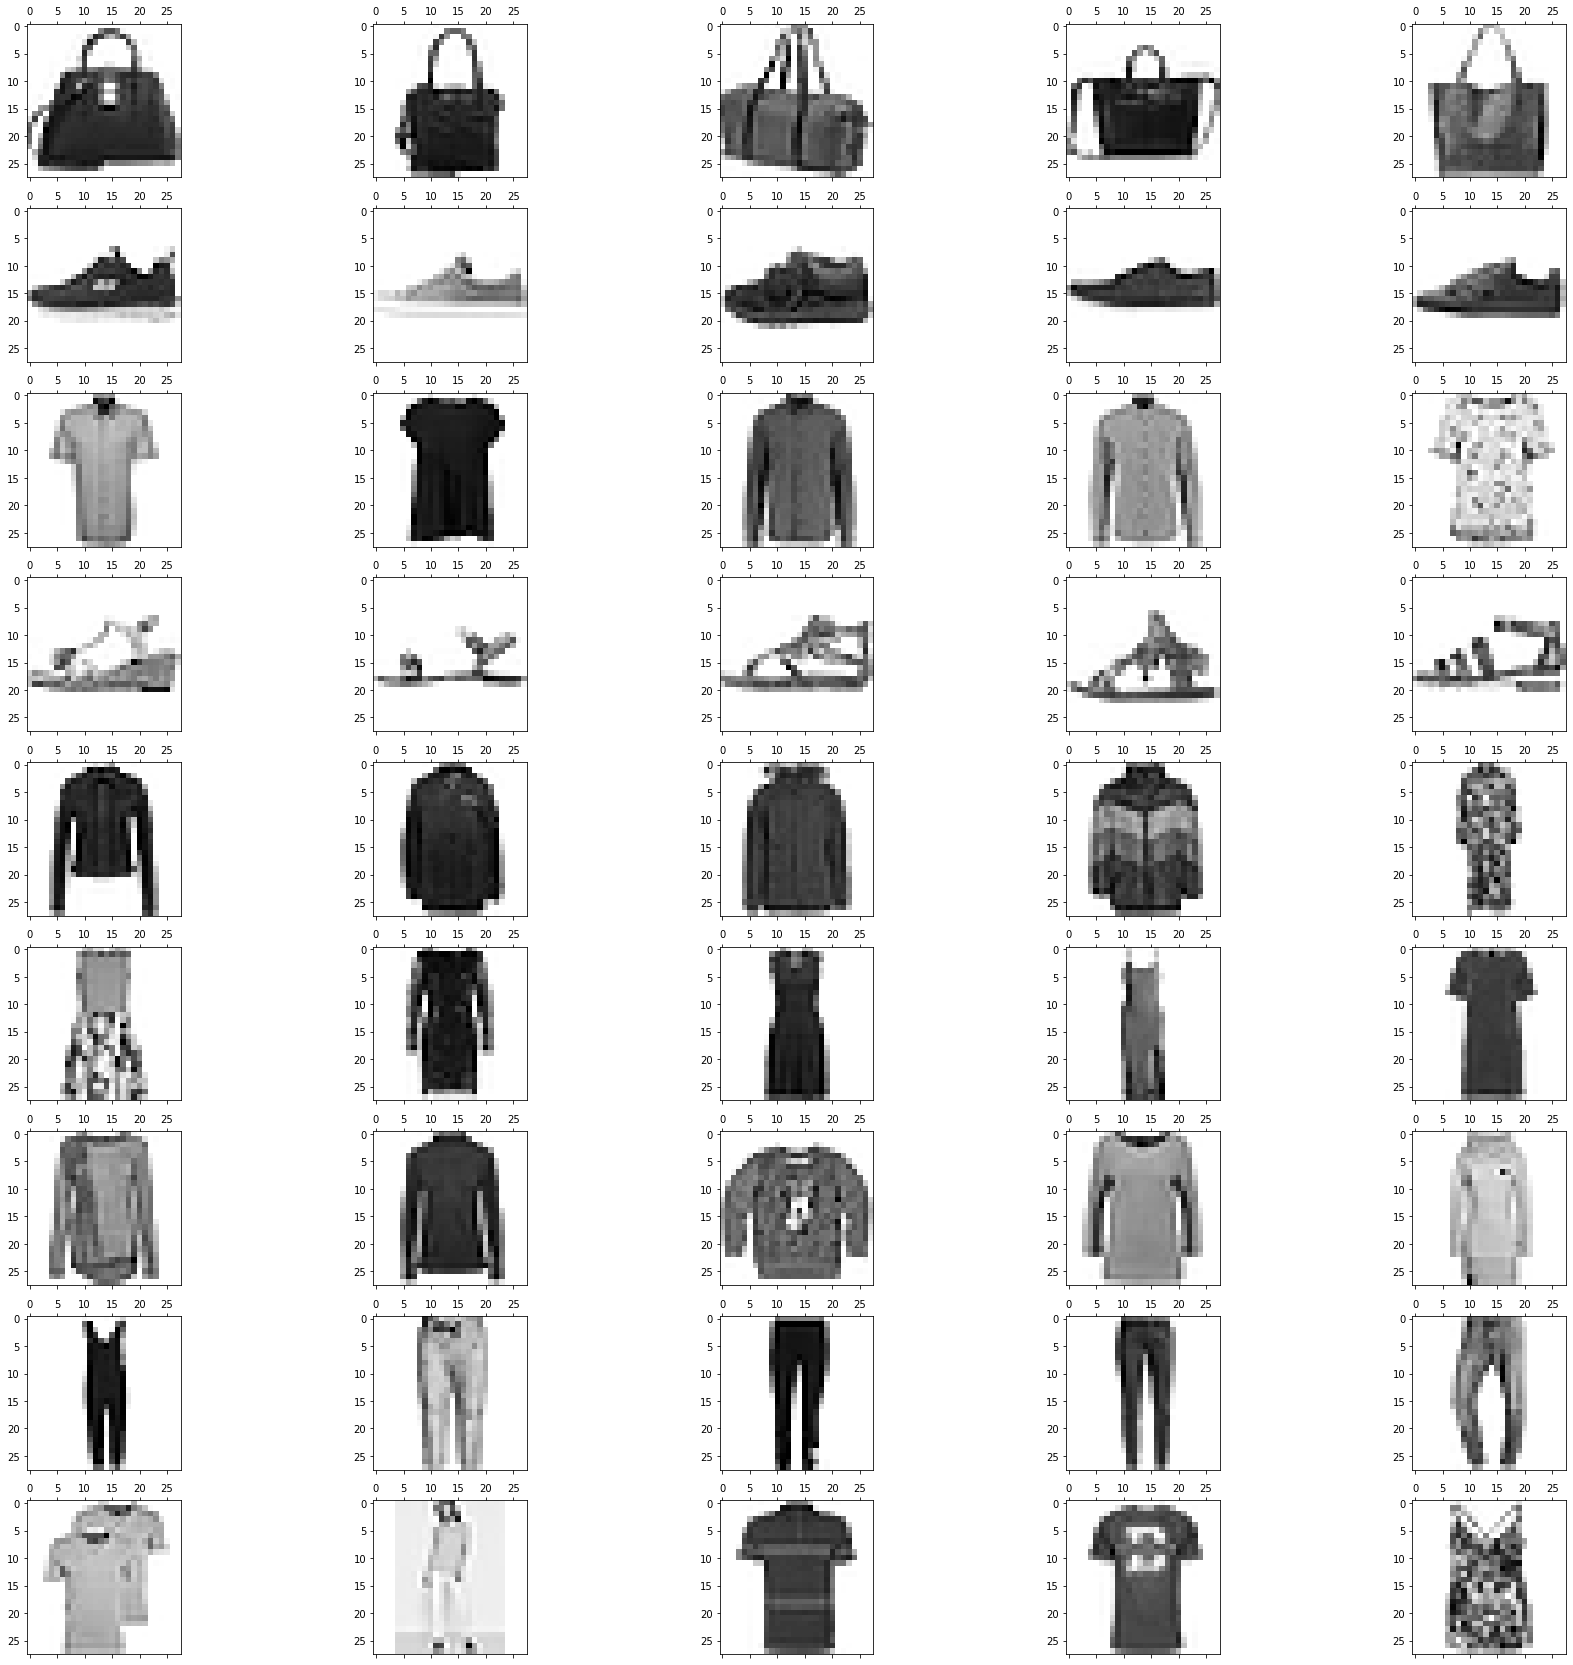

In [10]:
fig, axes = plt.subplots(9, 5, figsize=(30, 30))

for i in range(0, len(classes)):
    index = np.argwhere(ytrain == classes[i])[0:5]
    for j in range(0, 5):
        axes[i , j].matshow(xtrain1[index[j]].reshape(28,28), cmap=plt.get_cmap('gray'))

# Part B

In [11]:
max_value = np.amax(xtrain1)
min_value = np.amin(xtrain1)

means = []
for i in range(xtrain1.shape[0]):
    means.append(np.mean(xtrain1[i]))

mean_value = np.mean(np.array(means))
print("MAX: " + str(max_value) + "    MIN:" + str(min_value) +  "    MEAN:" + str(mean_value))

MAX: 255.0    MIN:0.0    MEAN:182.54231553416818


In [12]:
xtrain1_preprocessed = ((255 - xtrain1).astype("float32")) / 255.0
xtest_preprocessed = ((255 - xtest).astype("float32")) / 255.

In [13]:
xtrain1_preprocessed = xtrain1_preprocessed.reshape(xtrain1_preprocessed.shape[0], 28, 28, 1)
xtest_preprocessed = xtest_preprocessed.reshape(xtest_preprocessed.shape[0], 28, 28, 1)

In [14]:
#xtrain1_preprocessed, ytrain_preprocessed = shuffle(xtrain1_preprocessed, ytrain)
ytrain_preprocessed = ytrain.copy()

In [15]:
max_value = np.amax(xtrain1_preprocessed)
min_value = np.amin(xtrain1_preprocessed)

means = []
for i in range(xtrain1_preprocessed.shape[0]):
    means.append(np.mean(xtrain1_preprocessed[i]))

mean_value = np.mean(np.array(means))
print("MAX: " + str(max_value) + "    MIN:" + str(min_value) +  "    MEAN:" + str(mean_value))

MAX: 1.0    MIN:0.0    MEAN:0.2841478


In [16]:
ytrain_preprocessed = tf.keras.utils.to_categorical(ytrain_preprocessed - class_name_bias, num_classes)
ytest_preprocessed = tf.keras.utils.to_categorical(ytest - class_name_bias, num_classes)

In [17]:
xtrain1_preprocessed.shape

(47520, 28, 28, 1)

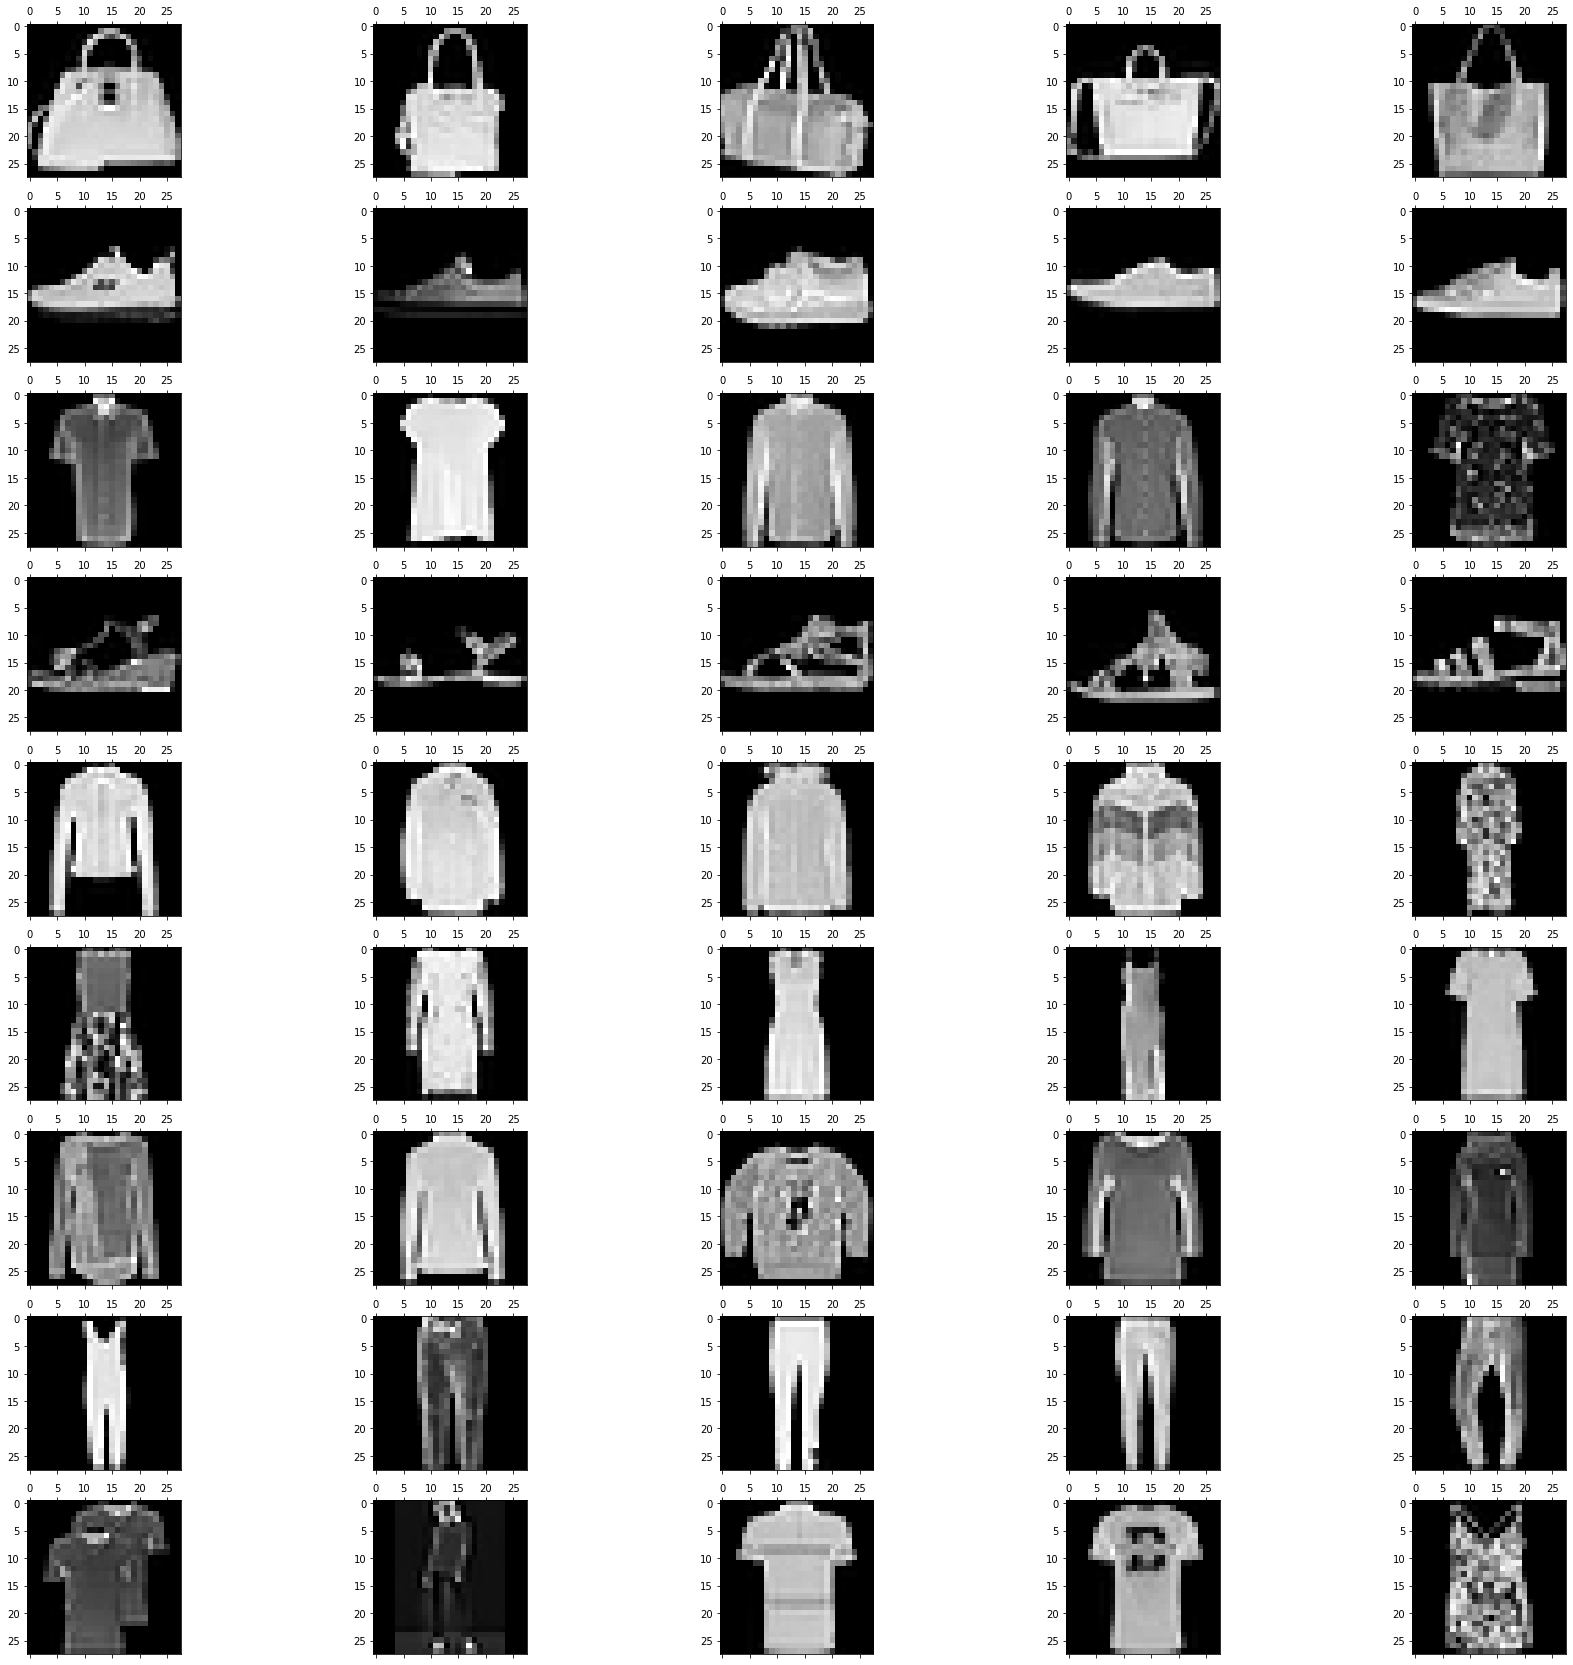

In [19]:
fig, axes = plt.subplots(9, 5, figsize=(30, 30))

for i in range(0, len(classes)):
    index = np.argwhere(ytrain == classes[i] )[0:5]
    for j in range(0, 5):
        axes[i , j].matshow(xtrain1_preprocessed[index[j]].reshape(28,28), cmap=plt.get_cmap('gray'))

# Part C

For my architecure I have chosen a multi layer convnet. It has three copies of (conv + conv + maxpool) followed by 2 layers of fullyconnected dense net. Each level of convolutions is same as or larger than the previous one. It starts with 128x(3x3) filters, and goes to 256(3x3). We would like to create complex features as we go deeper and should give the network the opportunity to choose winners from a large pool. The densenet at the end looks at these complex features and combines the information, which is then interpreted by the last softmax layer. I have tried tanh, sigmoid and relu for various stages as activations. Relu performed the best due it's increased non-linearity.

In [20]:
def eval_model(model, xtrain, ytrain, xtest, ytest):
    score = model.evaluate(xtrain, ytrain, verbose=verbose_)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    score = model.evaluate(xtest, ytest, verbose=verbose_)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print("--------------------------------")
    y_pred = np.argmax(model.predict(xtest), axis=1)
    ytest_true = np.argmax(ytest, axis=1)
    print(classification_report(ytest_true, y_pred))
    print("--------------------------------")
    cm = confusion_matrix(ytest_true, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.show()

In [21]:
def plot_history(history):
    plt.figure(figsize=(12,6))
    grid = plt.GridSpec(1, 2)
    plt.subplot(grid[0,0])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.subplot(grid[0,1])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [22]:
def model_initial():
    tf.keras.backend.clear_session()
    model =  tf.keras.Sequential()
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.25),
                  metrics=['accuracy'])
    return model

In [23]:
def trainer(model, xtrain, ytrain):
    history = model.fit(xtrain, ytrain, \
                        batch_size=batch_size_, epochs=epochs_, verbose=verbose_, \
                        validation_split=0.15, shuffle=True, workers=0, use_multiprocessing=False)
    return model, history

In [24]:
nn_initial_model = model_initial()
nn_initial_model_trained, history = trainer(nn_initial_model, xtrain1_preprocessed, ytrain_preprocessed)

Epoch 1/40
1263/1263 [==============================] - 11s 9ms/step - loss: 0.4728 - accuracy: 0.8256 - val_loss: 0.3421 - val_accuracy: 0.8729
Epoch 2/40
1263/1263 [==============================] - 11s 9ms/step - loss: 0.2827 - accuracy: 0.8976 - val_loss: 0.2976 - val_accuracy: 0.8887
Epoch 3/40
1263/1263 [==============================] - 11s 9ms/step - loss: 0.2277 - accuracy: 0.9156 - val_loss: 0.2991 - val_accuracy: 0.8885
Epoch 4/40
1263/1263 [==============================] - 11s 9ms/step - loss: 0.1849 - accuracy: 0.9310 - val_loss: 0.2553 - val_accuracy: 0.9061
Epoch 5/40
1263/1263 [==============================] - 11s 9ms/step - loss: 0.1515 - accuracy: 0.9440 - val_loss: 0.3085 - val_accuracy: 0.8899
Epoch 6/40
1263/1263 [==============================] - 11s 9ms/step - loss: 0.1203 - accuracy: 0.9562 - val_loss: 0.2887 - val_accuracy: 0.9111
Epoch 7/40
1263/1263 [==============================] - 11s 9ms/step - loss: 0.0932 - accuracy: 0.9646 - val_loss: 0.3557 - val_ac

1485/1485 [==============================] - 6s 4ms/step - loss: 0.1257 - accuracy: 0.9888
Train loss: 0.1256786286830902
Train accuracy: 0.9888257384300232
203/203 [==============================] - 1s 5ms/step - loss: 0.8588 - accuracy: 0.9293
Test loss: 0.8588307499885559
Test accuracy: 0.9293209910392761
--------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       800
           1       0.99      0.99      0.99       700
           2       0.81      0.79      0.80       723
           3       0.99      0.99      0.99       714
           4       0.88      0.89      0.89       737
           5       0.92      0.93      0.93       685
           6       0.90      0.89      0.90       716
           7       0.99      0.99      0.99       701
           8       0.87      0.89      0.88       704

    accuracy                           0.93      6480
   macro avg       0.93      0.93      0.93      6480
weighte

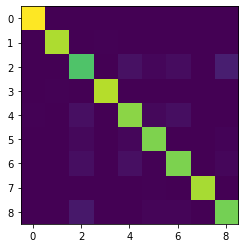

In [25]:
eval_model(nn_initial_model_trained, xtrain1_preprocessed, ytrain_preprocessed, xtest_preprocessed, ytest_preprocessed)

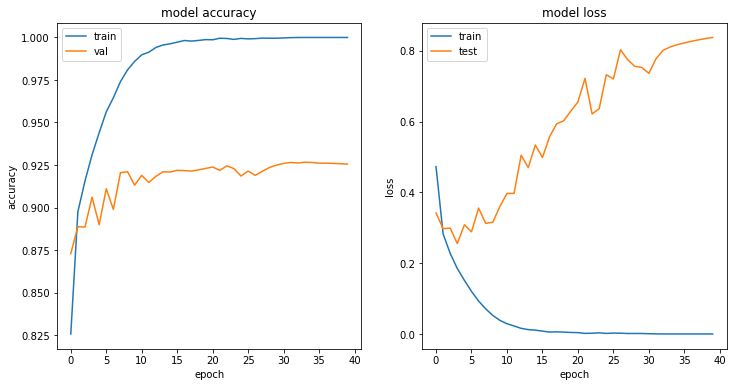

In [26]:
plot_history(history)

In [27]:
nn_initial_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1280      
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0

In [28]:
tf.keras.backend.clear_session()

# Part D

The model loss plot from Part C shows that my inital model is grossly over fitting. Loss for validation first decreases; but starts increasing abruptly after a while. The accuracy for training set is 100% and validation set get 93%. This means that my model is memorizing the training set and not learning the rules. In other words it's variance is high, bias is low. To counter this I have used weight decay, batchnorm, dropout and earlystop. I have added each regularization technique separately to see how they affect the outcome; and then combined them into a final model. 

I have started with weight decay. I have tried L1, L2 and L1_L2. L1 regularization failed to converge. Since my model is somewhat large, there are significant number of weights; and the cumulative L1 cost becomes unbearable for the gradient descent. Unless we make the regularization value very very small, L1 causes the model to grossly underfit. 

Second technique I have tried was L2. I have tried 3 different L2 values. 0.01, 0.001 and  0.0001. L2 does significantly better than L1. This is because L2 also penalizes number of active nodes and forces my model to get rid of unnecessary nodes which means that we get rid of the extra variance they bring. This helps us to have a better bias and a more robust predictor. Of the three values, first one was too restrictive. the loss function for validation and training sets were very close, but prediction accuracy suffered quite a bit and our model converged to a point well below it's potential (high bias). The third value was the mirror opposite. It resembled the original model and overfit. 0.001 seemed like the sweet spot where the training and validation loss curves were close enough and accuracy did not suffer as much. But generally speaking we lost a high degree of accuracy in this step, which means that we should use it sparingly.

Next technique I have tried was dropout. This technique performed significantly better than the others in terms of loss and accuracy. The loss functions for validation got very close to the training set. Accuracy for training set went down but the accuracy for the validation set actually increased slightly. So we decreased our variance and kept our performance. Dropout is clearly good for us.

Next was batchnorm. Batchnorm averages the outputs from previous layers, so acts as a dampener. It decreases variance and this is evident once again in the loss function. Our loss function no longer turns up. However it does not follow the training set either. So batchnorm helps, but is not the solution.

Next step is earlystop. In this technique we let our model train freely but when it starts to overfit we tell it to stop. For this purpose we track the validation loss and if it starts to go higher we stop the training. Just like batchnorm earlystop helps, but is not the answer on it's own. It does not change the behavior of the model or  the bias/variance tradeoff. 

After studying all techniques separately, I have created my final model and applied all the techniques together. However in my first attempts it did not work very well and could not match the performance of the initial model. In other words the model became to conservative and under-fitted. So I have increased the momentum of training and  the learning rate. This has caused the model achieve higher accuracy but it also caused it to overfit. The high learning rate caused big swings in the loss and could not follow the training loss function. So I have decreased the learning rate gradually. This way optimizer could take smaller steps to find the best point on the variance/bias curve. With this model I got 94.3% accuracy.

Another important thing was the batch size; and this is where I ran into issues. My notebook kept crashing; and in order to be able to run it from beginning to end I had to set the batch_size to 256. The higher batch_size decreased the performance of my model significantly. The higher batch size causes the gradient descent to happen less often and with a higher average error. Lowering the batch_number actually helps finding a more optimal solution.    
##### For this reason, I am attaching a second notebook which runs my final model standalone with a batch_size of 64 (instead of 256). With this model I have achieved  95% accuracy and 0.25 validation loss instead of 94% & 0.33. The results I have submitted for Q3 is from this second notebook.

Regardless of what steps I took I could not exceed the 95% accuracy. Even when I let the model overfit a bit, the accuracy never got better. The decrease in loss did not materialize as an increase in accuracy. I think this is due to the training set. When we look at the confusion matrix, we can see that 3rd class regularly gets misclassified as other classes. I think this class is just too much for my network to handle and is too vague. In order to achieve better results I think I might need a random forest type voting mechanism between multiple convnet layers.

### Regularization1: Weight decay

In [29]:
def model_with_regularizer(regularizer_):
    tf.keras.backend.clear_session()
    model =  tf.keras.Sequential()
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',
                     kernel_regularizer=regularizer_))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizer_))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',
                     kernel_regularizer=regularizer_))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer_))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizer_))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizer_))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.25),
                  metrics=['accuracy'])

    return model

### L2 (0.01)

In [30]:
nn_model_l2_1 = model_with_regularizer(tf.keras.regularizers.l2(0.01))
nn_model_l2_1_trained, history = trainer(nn_model_l2_1, xtrain1_preprocessed, ytrain_preprocessed)

Epoch 1/40
1263/1263 [==============================] - 13s 10ms/step - loss: 6.1456 - accuracy: 0.7884 - val_loss: 1.2882 - val_accuracy: 0.8175
Epoch 2/40
1263/1263 [==============================] - 12s 10ms/step - loss: 0.9314 - accuracy: 0.8344 - val_loss: 0.8286 - val_accuracy: 0.8224
Epoch 3/40
1263/1263 [==============================] - 12s 10ms/step - loss: 0.7479 - accuracy: 0.8438 - val_loss: 0.7151 - val_accuracy: 0.8490
Epoch 4/40
1263/1263 [==============================] - 12s 9ms/step - loss: 0.6972 - accuracy: 0.8483 - val_loss: 0.7472 - val_accuracy: 0.8279
Epoch 5/40
1263/1263 [==============================] - 12s 9ms/step - loss: 0.6711 - accuracy: 0.8531 - val_loss: 0.7395 - val_accuracy: 0.8176
Epoch 6/40
1263/1263 [==============================] - 12s 10ms/step - loss: 0.6519 - accuracy: 0.8562 - val_loss: 0.6793 - val_accuracy: 0.8454
Epoch 7/40
1263/1263 [==============================] - 12s 9ms/step - loss: 0.6373 - accuracy: 0.8574 - val_loss: 0.6432 - va

1485/1485 [==============================] - 6s 4ms/step - loss: 0.4925 - accuracy: 0.8880
Train loss: 0.4925377666950226
Train accuracy: 0.8880261182785034
203/203 [==============================] - 1s 5ms/step - loss: 0.5121 - accuracy: 0.8784
Test loss: 0.5120527744293213
Test accuracy: 0.8783950805664062
--------------------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       800
           1       0.97      0.98      0.97       700
           2       0.68      0.72      0.70       723
           3       0.97      0.97      0.97       714
           4       0.77      0.85      0.81       737
           5       0.89      0.90      0.90       685
           6       0.86      0.74      0.80       716
           7       0.99      0.96      0.98       701
           8       0.84      0.80      0.82       704

    accuracy                           0.88      6480
   macro avg       0.88      0.88      0.88      6480
weighte

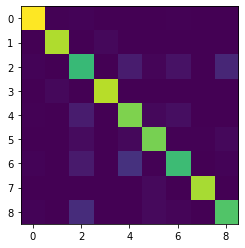

In [31]:
eval_model(nn_model_l2_1_trained, xtrain1_preprocessed, ytrain_preprocessed, xtest_preprocessed, ytest_preprocessed)

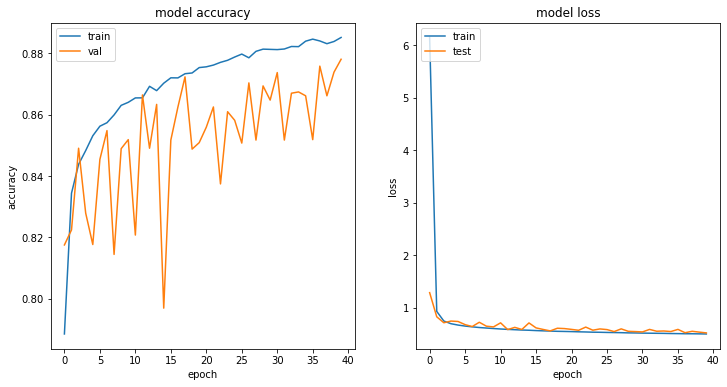

In [32]:
plot_history(history)

### L2 (0.001)

In [33]:
nn_model_l2_2 = model_with_regularizer(tf.keras.regularizers.l2(0.001))
nn_model_l2_2_trained, history = trainer(nn_model_l2_2, xtrain1_preprocessed, ytrain_preprocessed)

Epoch 1/40
1263/1263 [==============================] - 12s 9ms/step - loss: 2.6290 - accuracy: 0.8265 - val_loss: 1.8370 - val_accuracy: 0.8422
Epoch 2/40
1263/1263 [==============================] - 11s 9ms/step - loss: 1.2898 - accuracy: 0.8893 - val_loss: 1.0211 - val_accuracy: 0.8798
Epoch 3/40
1263/1263 [==============================] - 11s 9ms/step - loss: 0.7825 - accuracy: 0.9061 - val_loss: 0.8568 - val_accuracy: 0.8326
Epoch 4/40
1263/1263 [==============================] - 11s 9ms/step - loss: 0.5645 - accuracy: 0.9144 - val_loss: 0.6729 - val_accuracy: 0.8601
Epoch 5/40
1263/1263 [==============================] - 11s 9ms/step - loss: 0.4638 - accuracy: 0.9197 - val_loss: 0.4918 - val_accuracy: 0.8996
Epoch 6/40
1263/1263 [==============================] - 11s 9ms/step - loss: 0.4089 - accuracy: 0.9253 - val_loss: 0.4319 - val_accuracy: 0.9125
Epoch 7/40
1263/1263 [==============================] - 11s 9ms/step - loss: 0.3743 - accuracy: 0.9310 - val_loss: 0.4439 - val_ac

1485/1485 [==============================] - 6s 4ms/step - loss: 0.2394 - accuracy: 0.9644
Train loss: 0.23940065503120422
Train accuracy: 0.9643728733062744
203/203 [==============================] - 1s 4ms/step - loss: 0.4917 - accuracy: 0.9063
Test loss: 0.49168556928634644
Test accuracy: 0.9063271880149841
--------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       800
           1       0.98      1.00      0.99       700
           2       0.88      0.60      0.72       723
           3       1.00      0.97      0.99       714
           4       0.88      0.86      0.87       737
           5       0.90      0.91      0.91       685
           6       0.86      0.89      0.87       716
           7       0.99      0.99      0.99       701
           8       0.73      0.94      0.83       704

    accuracy                           0.91      6480
   macro avg       0.91      0.91      0.90      6480
weigh

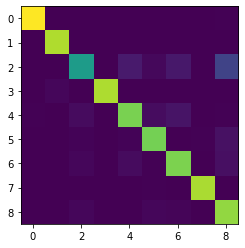

In [34]:
eval_model(nn_model_l2_2_trained, xtrain1_preprocessed, ytrain_preprocessed, xtest_preprocessed, ytest_preprocessed)

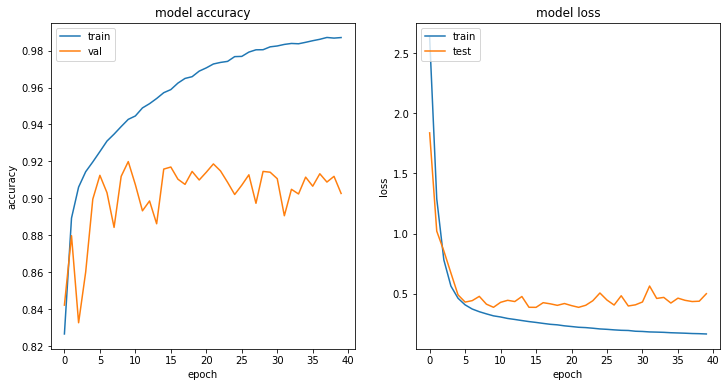

In [35]:
plot_history(history)

### L2 (0.0001)

In [36]:
nn_model_l2_3 = model_with_regularizer(tf.keras.regularizers.l2(0.0001))
nn_model_l2_3_trained, history = trainer(nn_model_l2_3, xtrain1_preprocessed, ytrain_preprocessed)

Epoch 1/40
158/158 [==============================] - 8s 48ms/step - loss: 1.0454 - accuracy: 0.7261 - val_loss: 0.7677 - val_accuracy: 0.8318
Epoch 2/40
158/158 [==============================] - 7s 43ms/step - loss: 0.7247 - accuracy: 0.8473 - val_loss: 0.6590 - val_accuracy: 0.8701
Epoch 3/40
158/158 [==============================] - 7s 43ms/step - loss: 0.6467 - accuracy: 0.8738 - val_loss: 0.6271 - val_accuracy: 0.8837
Epoch 4/40
158/158 [==============================] - 6s 41ms/step - loss: 0.6025 - accuracy: 0.8893 - val_loss: 0.6425 - val_accuracy: 0.8737
Epoch 5/40
158/158 [==============================] - 7s 42ms/step - loss: 0.5681 - accuracy: 0.9006 - val_loss: 0.6826 - val_accuracy: 0.8690
Epoch 6/40
158/158 [==============================] - 7s 43ms/step - loss: 0.5374 - accuracy: 0.9107 - val_loss: 0.5801 - val_accuracy: 0.8932
Epoch 7/40
158/158 [==============================] - 7s 42ms/step - loss: 0.5140 - accuracy: 0.9193 - val_loss: 0.5703 - val_accuracy: 0.8987

1485/1485 [==============================] - 6s 4ms/step - loss: 0.2674 - accuracy: 0.9878
Train loss: 0.26739948987960815
Train accuracy: 0.987773597240448
203/203 [==============================] - 1s 5ms/step - loss: 0.5960 - accuracy: 0.9244
Test loss: 0.5960212349891663
Test accuracy: 0.9243826866149902
--------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       800
           1       0.99      0.99      0.99       700
           2       0.78      0.80      0.79       723
           3       0.99      0.99      0.99       714
           4       0.90      0.90      0.90       737
           5       0.91      0.94      0.92       685
           6       0.90      0.87      0.88       716
           7       0.99      0.99      0.99       701
           8       0.88      0.86      0.87       704

    accuracy                           0.92      6480
   macro avg       0.92      0.92      0.92      6480
weighte

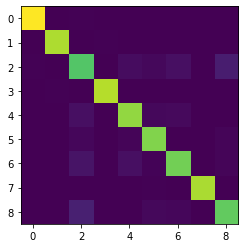

In [37]:
eval_model(nn_model_l2_3_trained, xtrain1_preprocessed, ytrain_preprocessed, xtest_preprocessed, ytest_preprocessed)

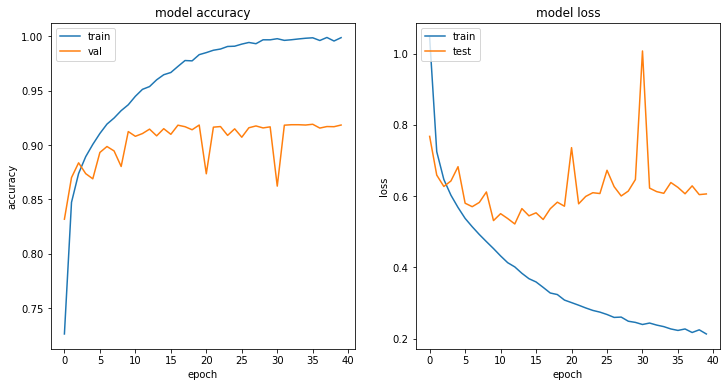

In [38]:
plot_history(history)

### L2_L1 (0.0001)

In [39]:
nn_model_l1_l2 = model_with_regularizer(tf.keras.regularizers.l1_l2(0.0001))
nn_model_l1_l2_trained, history = trainer(nn_model_l1_l2, xtrain1_preprocessed, ytrain_preprocessed)

Epoch 1/40
158/158 [==============================] - 7s 43ms/step - loss: 26.4457 - accuracy: 0.7057 - val_loss: 16.0729 - val_accuracy: 0.8046
Epoch 2/40
158/158 [==============================] - 7s 42ms/step - loss: 10.8595 - accuracy: 0.8081 - val_loss: 7.2063 - val_accuracy: 0.7632
Epoch 3/40
158/158 [==============================] - 7s 43ms/step - loss: 5.1806 - accuracy: 0.8214 - val_loss: 3.8416 - val_accuracy: 0.8150
Epoch 4/40
158/158 [==============================] - 7s 42ms/step - loss: 3.1188 - accuracy: 0.8265 - val_loss: 2.5624 - val_accuracy: 0.8394
Epoch 5/40
158/158 [==============================] - 7s 42ms/step - loss: 2.2269 - accuracy: 0.8315 - val_loss: 1.9843 - val_accuracy: 0.8085
Epoch 6/40
158/158 [==============================] - 7s 43ms/step - loss: 1.7289 - accuracy: 0.8328 - val_loss: 1.5413 - val_accuracy: 0.8354
Epoch 7/40
158/158 [==============================] - 7s 44ms/step - loss: 1.4025 - accuracy: 0.8393 - val_loss: 1.3472 - val_accuracy: 0.8

1485/1485 [==============================] - 6s 4ms/step - loss: 0.6166 - accuracy: 0.8740
Train loss: 0.6165643930435181
Train accuracy: 0.8739898800849915
203/203 [==============================] - 1s 4ms/step - loss: 0.6266 - accuracy: 0.8665
Test loss: 0.6266295313835144
Test accuracy: 0.8665123581886292
--------------------------------
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       800
           1       0.97      0.97      0.97       700
           2       0.68      0.67      0.68       723
           3       0.96      0.97      0.97       714
           4       0.75      0.86      0.80       737
           5       0.83      0.91      0.87       685
           6       0.81      0.76      0.78       716
           7       0.97      0.97      0.97       701
           8       0.86      0.72      0.78       704

    accuracy                           0.87      6480
   macro avg       0.87      0.87      0.87      6480
weighte

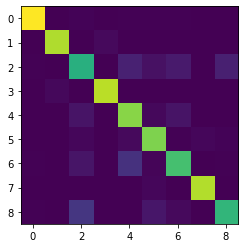

In [40]:
eval_model(nn_model_l1_l2_trained, xtrain1_preprocessed, ytrain_preprocessed, xtest_preprocessed, ytest_preprocessed)

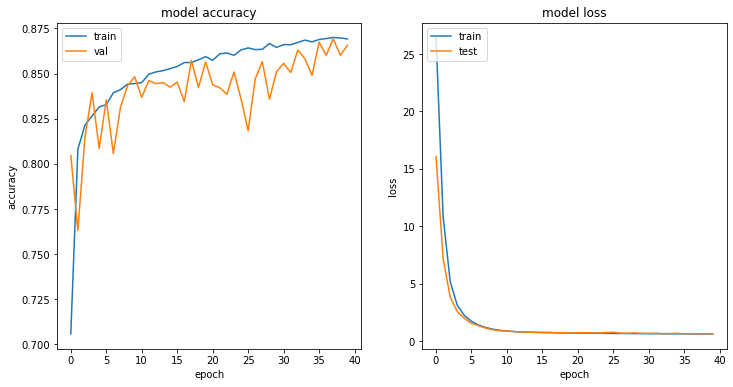

In [41]:
plot_history(history)

## Dropout

In [42]:
def model_with_dropout(d1=0.2, d2=0.4, d3=0.4, d4=0.5, d5=0.1):
    tf.keras.backend.clear_session()
    model =  tf.keras.Sequential()
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(d1))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(d2))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(d3))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(d4))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(d5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.25),
                  metrics=['accuracy'])
    
    return model

In [43]:
nn_model_dropout = model_with_dropout()
nn_model_dropout_trained, history = trainer(nn_model_dropout, xtrain1_preprocessed, ytrain_preprocessed)

Epoch 1/40
158/158 [==============================] - 7s 43ms/step - loss: 1.0913 - accuracy: 0.5893 - val_loss: 0.6712 - val_accuracy: 0.7607
Epoch 2/40
158/158 [==============================] - 7s 42ms/step - loss: 0.6372 - accuracy: 0.7632 - val_loss: 0.5006 - val_accuracy: 0.8246
Epoch 3/40
158/158 [==============================] - 7s 42ms/step - loss: 0.5304 - accuracy: 0.8057 - val_loss: 0.4370 - val_accuracy: 0.8450
Epoch 4/40
158/158 [==============================] - 7s 42ms/step - loss: 0.4669 - accuracy: 0.8279 - val_loss: 0.3866 - val_accuracy: 0.8636
Epoch 5/40
158/158 [==============================] - 7s 42ms/step - loss: 0.4256 - accuracy: 0.8447 - val_loss: 0.3673 - val_accuracy: 0.8655
Epoch 6/40
158/158 [==============================] - 7s 43ms/step - loss: 0.3966 - accuracy: 0.8541 - val_loss: 0.3417 - val_accuracy: 0.8753
Epoch 7/40
158/158 [==============================] - 7s 43ms/step - loss: 0.3751 - accuracy: 0.8599 - val_loss: 0.3323 - val_accuracy: 0.8777

1485/1485 [==============================] - 6s 4ms/step - loss: 0.1305 - accuracy: 0.9538
Train loss: 0.13046717643737793
Train accuracy: 0.9538299441337585
203/203 [==============================] - 1s 4ms/step - loss: 0.1871 - accuracy: 0.9327
Test loss: 0.1871260106563568
Test accuracy: 0.9327160716056824
--------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       800
           1       0.99      0.99      0.99       700
           2       0.85      0.76      0.80       723
           3       0.99      0.99      0.99       714
           4       0.90      0.90      0.90       737
           5       0.90      0.96      0.93       685
           6       0.88      0.91      0.89       716
           7       1.00      0.98      0.99       701
           8       0.88      0.90      0.89       704

    accuracy                           0.93      6480
   macro avg       0.93      0.93      0.93      6480
weight

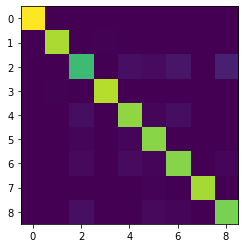

In [44]:
eval_model(nn_model_dropout_trained, xtrain1_preprocessed, ytrain_preprocessed, xtest_preprocessed, ytest_preprocessed)

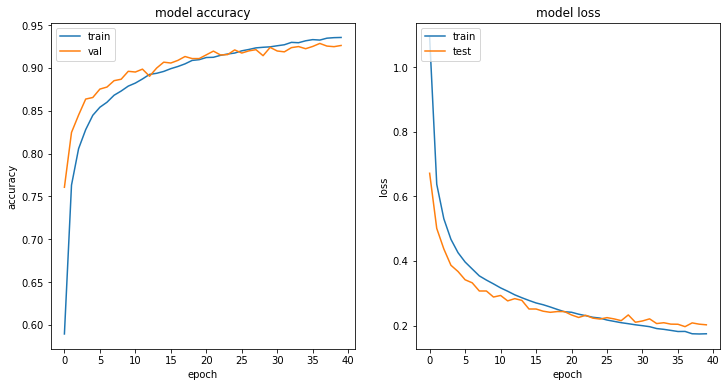

In [45]:
plot_history(history)

## Batchnorm

In [46]:
def model_with_batchnorm():
    tf.keras.backend.clear_session()
    model =  tf.keras.Sequential()
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.25),
                  metrics=['accuracy'])
    return model

In [47]:
nn_model_batchnorm = model_with_batchnorm()
nn_model_batchnorm_trained, history = trainer(nn_model_batchnorm, xtrain1_preprocessed, ytrain_preprocessed)

Epoch 1/40
158/158 [==============================] - 8s 50ms/step - loss: 0.4248 - accuracy: 0.8503 - val_loss: 1.4925 - val_accuracy: 0.5010
Epoch 2/40
158/158 [==============================] - 7s 46ms/step - loss: 0.2700 - accuracy: 0.9012 - val_loss: 0.9846 - val_accuracy: 0.6803
Epoch 3/40
158/158 [==============================] - 7s 46ms/step - loss: 0.2203 - accuracy: 0.9197 - val_loss: 0.4846 - val_accuracy: 0.8192
Epoch 4/40
158/158 [==============================] - 7s 46ms/step - loss: 0.1818 - accuracy: 0.9334 - val_loss: 0.2816 - val_accuracy: 0.8994
Epoch 5/40
158/158 [==============================] - 7s 46ms/step - loss: 0.1536 - accuracy: 0.9453 - val_loss: 0.3987 - val_accuracy: 0.8601
Epoch 6/40
158/158 [==============================] - 7s 46ms/step - loss: 0.1246 - accuracy: 0.9550 - val_loss: 0.2789 - val_accuracy: 0.9059
Epoch 7/40
158/158 [==============================] - 7s 46ms/step - loss: 0.1027 - accuracy: 0.9640 - val_loss: 0.4821 - val_accuracy: 0.8401

1485/1485 [==============================] - 6s 4ms/step - loss: 0.0527 - accuracy: 0.9891
Train loss: 0.05269024148583412
Train accuracy: 0.9890782833099365
203/203 [==============================] - 1s 5ms/step - loss: 0.3723 - accuracy: 0.9298
Test loss: 0.37233254313468933
Test accuracy: 0.9297839403152466
--------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       800
           1       0.99      0.99      0.99       700
           2       0.82      0.78      0.80       723
           3       0.99      0.99      0.99       714
           4       0.90      0.91      0.91       737
           5       0.91      0.95      0.93       685
           6       0.90      0.90      0.90       716
           7       0.99      0.99      0.99       701
           8       0.88      0.87      0.87       704

    accuracy                           0.93      6480
   macro avg       0.93      0.93      0.93      6480
weigh

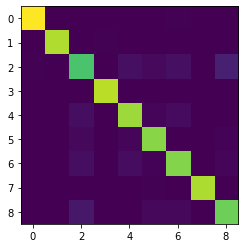

In [48]:
eval_model(nn_model_batchnorm_trained, xtrain1_preprocessed, ytrain_preprocessed, xtest_preprocessed, ytest_preprocessed)

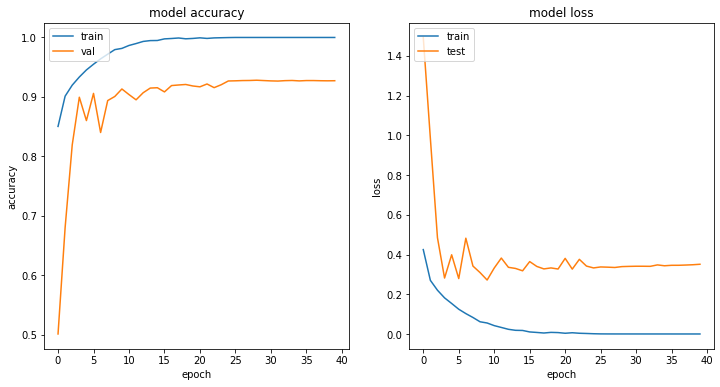

In [49]:
plot_history(history)

## Early Stop

In [50]:
def trainer_early(model, xtrain, ytrain, early=6):
    callbacks = [EarlyStopping(monitor='val_loss', patience=early),
                 ModelCheckpoint(filepath='best_model_early.h5', monitor='val_loss', save_best_only=True)]
    history = model.fit(xtrain, ytrain, \
                        batch_size=batch_size_, epochs=epochs_, verbose=verbose_,
                        validation_split=0.15, shuffle=True, callbacks=callbacks)
    model = load_model('best_model_early.h5')
    return model, history

In [51]:
nn_early_model = model_initial()
nn_early_model_trained, history = trainer_early(nn_early_model, xtrain1_preprocessed, ytrain_preprocessed)

Epoch 1/40
158/158 [==============================] - 7s 42ms/step - loss: 0.7474 - accuracy: 0.7225 - val_loss: 0.6722 - val_accuracy: 0.7618
Epoch 2/40
158/158 [==============================] - 6s 41ms/step - loss: 0.4208 - accuracy: 0.8470 - val_loss: 0.3914 - val_accuracy: 0.8514
Epoch 3/40
158/158 [==============================] - 6s 41ms/step - loss: 0.3443 - accuracy: 0.8752 - val_loss: 0.3269 - val_accuracy: 0.8792
Epoch 4/40
158/158 [==============================] - 7s 41ms/step - loss: 0.2998 - accuracy: 0.8893 - val_loss: 0.3132 - val_accuracy: 0.8844
Epoch 5/40
158/158 [==============================] - 6s 41ms/step - loss: 0.2668 - accuracy: 0.9019 - val_loss: 0.3482 - val_accuracy: 0.8715
Epoch 6/40
158/158 [==============================] - 7s 42ms/step - loss: 0.2422 - accuracy: 0.9102 - val_loss: 0.2873 - val_accuracy: 0.8921
Epoch 7/40
158/158 [==============================] - 7s 42ms/step - loss: 0.2141 - accuracy: 0.9218 - val_loss: 0.2661 - val_accuracy: 0.9003

1485/1485 [==============================] - 6s 4ms/step - loss: 0.1367 - accuracy: 0.9525
Train loss: 0.1367471069097519
Train accuracy: 0.9524831771850586
203/203 [==============================] - 1s 4ms/step - loss: 0.2537 - accuracy: 0.9114
Test loss: 0.25367674231529236
Test accuracy: 0.9114197492599487
--------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       800
           1       1.00      0.97      0.98       700
           2       0.79      0.75      0.77       723
           3       0.97      1.00      0.98       714
           4       0.88      0.83      0.86       737
           5       0.90      0.94      0.92       685
           6       0.79      0.91      0.85       716
           7       0.99      0.99      0.99       701
           8       0.90      0.83      0.86       704

    accuracy                           0.91      6480
   macro avg       0.91      0.91      0.91      6480
weight

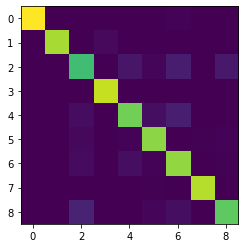

In [52]:
eval_model(nn_early_model_trained, xtrain1_preprocessed, ytrain_preprocessed, xtest_preprocessed, ytest_preprocessed)

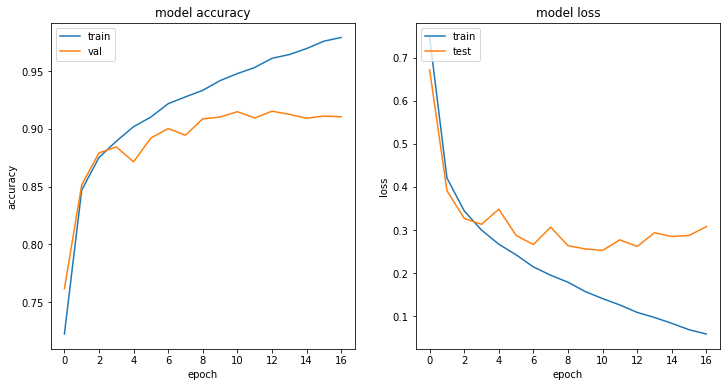

In [53]:
plot_history(history)

## Putting it all together

In [54]:
epochs_ = 80

In [55]:
def model_final():
    regularizer_ = tf.keras.regularizers.l2(0.0006)

    model = tf.keras.Sequential()
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizer_))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer_))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizer_))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer_))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.6))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizer_))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizer_))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))


    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(rho=0.99, epsilon=1e-08),
                  metrics=['accuracy'])
    return model

In [56]:
def scheduler(epoch):
    if epoch < 10:
        return 1.0
    else:
        return max(0.0005, 1.0 / (2**int((epoch-10)/10)))

In [57]:
def trainer_final(model, xtrain, ytrain):
    lrs = LearningRateScheduler(scheduler, verbose=verbose_)

    history = model.fit(xtrain, ytrain,
                        batch_size=batch_size_, epochs=epochs_, verbose=verbose_,
                        validation_split=0.15, shuffle=True,
                        callbacks=[lrs, 
                                   EarlyStopping(monitor='val_loss', patience=6),
                                   ModelCheckpoint(filepath='final_best_model.h5', 
                                                   monitor='val_accuracy', save_best_only=True)])
    model = load_model('final_best_model.h5')
    return model, history

In [58]:
nn_final_model = model_final()
nn_final_model_trained, history = trainer_final(nn_final_model, xtrain1_preprocessed, ytrain_preprocessed)


Epoch 00001: LearningRateScheduler reducing learning rate to 1.0.
Epoch 1/80
158/158 [==============================] - 8s 49ms/step - loss: 2.9606 - accuracy: 0.6378 - val_loss: 3.1298 - val_accuracy: 0.5687 - lr: 1.0000

Epoch 00002: LearningRateScheduler reducing learning rate to 1.0.
Epoch 2/80
158/158 [==============================] - 8s 48ms/step - loss: 2.3825 - accuracy: 0.7612 - val_loss: 2.6910 - val_accuracy: 0.6623 - lr: 1.0000

Epoch 00003: LearningRateScheduler reducing learning rate to 1.0.
Epoch 3/80
158/158 [==============================] - 8s 48ms/step - loss: 2.1987 - accuracy: 0.7981 - val_loss: 2.1972 - val_accuracy: 0.7991 - lr: 1.0000

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0.
Epoch 4/80
158/158 [==============================] - 8s 48ms/step - loss: 2.0384 - accuracy: 0.8194 - val_loss: 1.8928 - val_accuracy: 0.8478 - lr: 1.0000

Epoch 00005: LearningRateScheduler reducing learning rate to 1.0.
Epoch 5/80
158/158 [=====================

1485/1485 [==============================] - 6s 4ms/step - loss: 0.2297 - accuracy: 0.9789
Train loss: 0.2296917587518692
Train accuracy: 0.9788931012153625
203/203 [==============================] - 1s 4ms/step - loss: 0.3299 - accuracy: 0.9434
Test loss: 0.3299359679222107
Test accuracy: 0.9433642029762268
--------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       800
           1       1.00      1.00      1.00       700
           2       0.83      0.84      0.83       723
           3       1.00      1.00      1.00       714
           4       0.93      0.90      0.92       737
           5       0.92      0.95      0.94       685
           6       0.92      0.93      0.92       716
           7       1.00      0.99      0.99       701
           8       0.91      0.89      0.90       704

    accuracy                           0.94      6480
   macro avg       0.94      0.94      0.94      6480
weighte

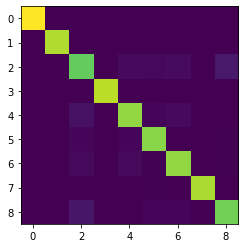

In [59]:
eval_model(nn_final_model_trained, xtrain1_preprocessed, ytrain_preprocessed, xtest_preprocessed, ytest_preprocessed)

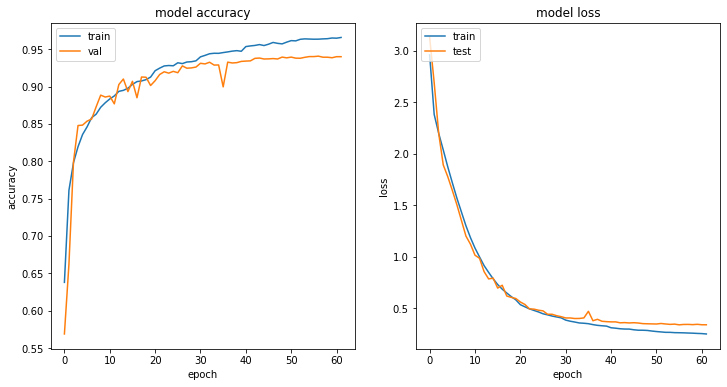

In [60]:
plot_history(history)

# Part E

Due to computational limitations and gpu crashes I could not run the x3 augmented case. However I was able to complete the x2. I have used zoom, shifts, shear, rotation and horizontal_flip. I expected the augmentation to work better than my final model. However this was not case. There were couple of issues. Due to constantly changing inputs the model failed to converge and grossly under-fit. So I had to decrease the amount of regularization (lower L2, dropout, larger earlystop values; and larger steps for learning rate decay). Even then, the accuracy for the learning set increased very slowly. Although the validation loss was almost identical to the training set, the accuracy never matched my results from my final model in Part D. I was expecting that increased dataset would help our model to learn the general case better. Our model is learning how to identify shifted, rotated, zoomed versions of the features; but our validation set does not have any of these properties. So we dont get a net gain from using this method. 

In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [62]:
def model_aug():
    regularizer_ = tf.keras.regularizers.l2(0.0002)

    model = tf.keras.Sequential()
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizer_))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer_))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizer_))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer_))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizer_))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizer_))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))


    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(rho=0.99, epsilon=1e-08),
                  metrics=['accuracy'])
    return model

In [63]:
def scheduler_aug(epoch):
    if epoch < 20:
        return 1.0
    else:
        return max(0.0005, 1.0 / (2**int((epoch-20)/10)))

In [64]:
def trainer_augmented(model, xtrain, ytrain, size=2):
    lrs = LearningRateScheduler(scheduler_aug, verbose=verbose_)
    
    xtrain_extended = np.repeat(xtrain, size, axis=0)
    ytrain_extended = np.repeat(ytrain, size, axis=0)
    
    datagen = ImageDataGenerator(validation_split=0.15, width_shift_range=0.1, height_shift_range=0.1, 
                                 horizontal_flip=True, zoom_range=0.1, fill_mode='nearest', shear_range=0.1,
                                 rotation_range=10)
    it_train = datagen.flow(xtrain_extended, ytrain_extended, batch_size=batch_size_, subset='training', shuffle=True)
    it_valid = datagen.flow(xtrain_extended, ytrain_extended, batch_size=batch_size_, subset='validation', shuffle=True)
    
    history = model.fit(it_train,
                        validation_data = it_valid,
                        steps_per_epoch = len(it_train),
                        validation_steps = len(it_valid),
                        epochs=epochs_, verbose=verbose_,
                        callbacks=[lrs, 
                                   EarlyStopping(monitor='val_loss', patience=6),
                                   ModelCheckpoint(filepath='aug_best_model.h5', monitor='val_accuracy', save_best_only=True)])
    model = load_model('aug_best_model.h5')
    return model, history

In [65]:
nn_augmented_2x_model = model_aug()
nn_augmented_2x_model_trained, history = trainer_augmented(nn_augmented_2x_model, xtrain1_preprocessed, ytrain_preprocessed, 2)


Epoch 00001: LearningRateScheduler reducing learning rate to 1.0.
Epoch 1/80
316/316 [==============================] - 17s 55ms/step - loss: 1.6184 - accuracy: 0.6438 - val_loss: 1.9989 - val_accuracy: 0.5375 - lr: 1.0000

Epoch 00002: LearningRateScheduler reducing learning rate to 1.0.
Epoch 2/80
316/316 [==============================] - 17s 55ms/step - loss: 1.2400 - accuracy: 0.7468 - val_loss: 1.1209 - val_accuracy: 0.7880 - lr: 1.0000

Epoch 00003: LearningRateScheduler reducing learning rate to 1.0.
Epoch 3/80
316/316 [==============================] - 17s 55ms/step - loss: 1.1241 - accuracy: 0.7778 - val_loss: 0.9781 - val_accuracy: 0.8266 - lr: 1.0000

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0.
Epoch 4/80
316/316 [==============================] - 17s 55ms/step - loss: 1.0312 - accuracy: 0.8019 - val_loss: 0.9034 - val_accuracy: 0.8453 - lr: 1.0000

Epoch 00005: LearningRateScheduler reducing learning rate to 1.0.
Epoch 5/80
316/316 [=================

316/316 [==============================] - 17s 54ms/step - loss: 0.2481 - accuracy: 0.9445 - val_loss: 0.2629 - val_accuracy: 0.9416 - lr: 0.0312

Epoch 00074: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 74/80
316/316 [==============================] - 17s 54ms/step - loss: 0.2472 - accuracy: 0.9461 - val_loss: 0.2657 - val_accuracy: 0.9399 - lr: 0.0312

Epoch 00075: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 75/80
316/316 [==============================] - 17s 54ms/step - loss: 0.2446 - accuracy: 0.9462 - val_loss: 0.2635 - val_accuracy: 0.9405 - lr: 0.0312

Epoch 00076: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 76/80
316/316 [==============================] - 17s 55ms/step - loss: 0.2451 - accuracy: 0.9464 - val_loss: 0.2643 - val_accuracy: 0.9402 - lr: 0.0312

Epoch 00077: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 77/80
316/316 [==============================] - 17s 55ms/step - loss: 0.2455 - accuracy: 

1485/1485 [==============================] - 5s 4ms/step - loss: 0.2095 - accuracy: 0.9599
Train loss: 0.20950445532798767
Train accuracy: 0.9598905444145203
203/203 [==============================] - 1s 4ms/step - loss: 0.2683 - accuracy: 0.9414
Test loss: 0.2682930529117584
Test accuracy: 0.9413580298423767
--------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      1.00      1.00       700
           2       0.77      0.89      0.82       723
           3       1.00      1.00      1.00       714
           4       0.92      0.92      0.92       737
           5       0.95      0.93      0.94       685
           6       0.96      0.89      0.92       716
           7       0.99      0.99      0.99       701
           8       0.91      0.87      0.89       704

    accuracy                           0.94      6480
   macro avg       0.94      0.94      0.94      6480
weight

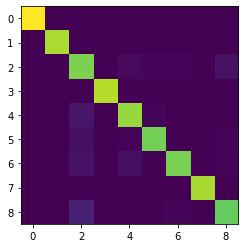

In [66]:
eval_model(nn_augmented_2x_model_trained, xtrain1_preprocessed, ytrain_preprocessed, xtest_preprocessed, ytest_preprocessed)

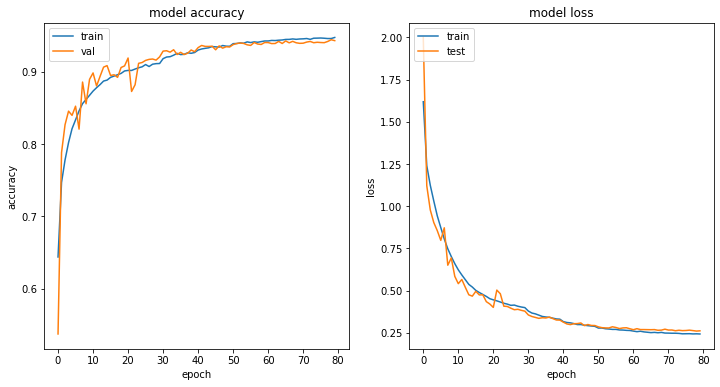

In [67]:
plot_history(history)

nn_augmented_3x_model = model_final()
nn_augmented_3x_model_trained, history = trainer_augmented(nn_augmented_3x_model, xtrain1_preprocessed, ytrain_preprocessed, 3)


eval_model(nn_augmented_3x_model_trained, xtrain1_preprocessed, ytrain_preprocessed, xtest_preprocessed, ytest_preprocessed)

plot_history(history)

(8 points) Q2. Try at least 2 others classical (non-neural-network) machine-learning algorithms that we covered in this class to classify the same dataset. Make sure to tune any hyper-parameters of the models and plot the accuracy as a function of the values of those parameters. Explain those plots. What accuracies do you get? Why did the accuracies increase or decrease with relation to the values of the hyper-parameters? Discussing this with the bias-variance tradeoff in mind will likely be useful. How do these compare to the accuracies you got in Q1? Explain why the accuracies are higher, lower, or similar in terms of the assumptions, strengths, and weaknesses of the classification techniques you used in Q1 and Q2. Use the same data augmentation techniques that you used in Q1c with these algorithms. Compare the change in accuracy due to augmentation that you got here and that in Q1c. Explain any differences you might find.

# Introduction

I am going to use Random Forest and KNN for Q2. Ideally I would have used SVM coupled with PCA (as we did in one of our previous homeworks). Although SVM is inherently a binary classifier it is succesful at classifying highly non-linear datasets (which was shown in our class project). However we have too much data and SVM was just too computationally intensive for a grid search. My second choice was another model we have used for our class project, Xgboost. However after some research I found out that it requires significant amount of hyperparameter tuning, which would be difficult to do with limited computing power. So I have opted for simpler algorithms.

PS: Discussions are at the end of each section

In [68]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

In [69]:
def eval_ml_model(model, xtest, ytest):
    y_pred = model.predict(xtest)
    accuracy = accuracy_score(ytest, y_pred)
    cm = confusion_matrix(ytest, y_pred)
    print("Accuracy score: " , accuracy)
    print("Confusion matrix: \n", cm)
    print('Plotting confusion matrix')

    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.show()

    print(classification_report(ytest, y_pred))

In [70]:
def plot_grid_search(cv_results, name, grid_param):
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param))

    _, ax = plt.subplots(1,1)
    ax.plot(grid_param, scores_mean, '-o', label= name)
    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

In [71]:
def gridsearch_and_plot(model, name, values, xtrain, ytrain):
    param_grid = {name: values}
    grid = GridSearchCV(model, param_grid, cv=5, n_jobs=6, verbose=10)
    grid.fit(xtrain, ytrain)
    print(grid.best_params_)
    plot_grid_search(grid.cv_results_, name, values)

In [72]:
xtrain2 = ((255 - xtrain1).astype("float32")) / 256
xtest2 = ((255 - xtest).astype("float32")) / 256
xtrain2_preprocessed = xtrain2.reshape((xtrain1.shape[0], 28*28))
xtest2_preprocessed = xtest2.reshape((xtest.shape[0], 28*28))
ytrain2 = ytrain - class_name_bias
ytest2 = ytest - class_name_bias

Our data has way too many dimensions (28*28). Some of these features may not be important (ex: the pixels on the boundaries) for our model. In order to reduce the computing time and to maximize the variance in the variables I will apply PCA first (like we did in hw5 with the digits testcase). Every component of the PCA would be a different representation of our image and this can be useful for our models.

99% point:  452


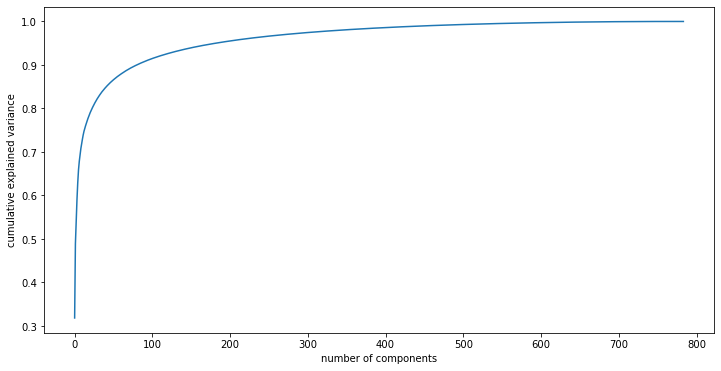

In [73]:
pca = PCA().fit(xtrain2_preprocessed)
plt.figure(figsize=(12,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
number_of_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >0.99)
print("99% point: ", number_of_components)

In [74]:
pca = PCA(number_of_components)
xtrain_pca = pca.fit_transform(xtrain2_preprocessed)
xtest_pca = pca.transform(xtest2_preprocessed)

# 1st Method: RandomForest

### With PCA

Accuracy score:  0.8550925925925926
Confusion matrix: 
 [[760   6   6  13   3   5   3   0   4]
 [  1 671   0  28   0   0   0   0   0]
 [ 12   0 390   2  69  22  79   0 149]
 [  5  24   1 684   0   0   0   0   0]
 [  6   0  41   0 613  20  55   1   1]
 [  1   0  20   0  15 616   6   2  25]
 [  9   0  47   0  90   5 554   0  11]
 [  2   0   5   0   2  25   4 661   2]
 [ 12   0  51   3   2  29  15   0 592]]
Plotting confusion matrix


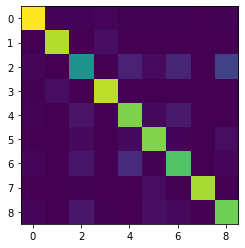

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95       800
         1.0       0.96      0.96      0.96       700
         2.0       0.70      0.54      0.61       723
         3.0       0.94      0.96      0.95       714
         4.0       0.77      0.83      0.80       737
         5.0       0.85      0.90      0.88       685
         6.0       0.77      0.77      0.77       716
         7.0       1.00      0.94      0.97       701
         8.0       0.76      0.84      0.80       704

    accuracy                           0.86      6480
   macro avg       0.85      0.85      0.85      6480
weighted avg       0.85      0.86      0.85      6480



In [75]:
randomforest_model = RandomForestClassifier(oob_score=True, warm_start=True, n_jobs=-1)
randomforest_model.fit(xtrain_pca, ytrain2)
eval_ml_model(randomforest_model, xtest_pca, ytest2)

### Without PCA

Accuracy score:  0.8804012345679012
Confusion matrix: 
 [[781   2  12   1   2   1   1   0   0]
 [  2 682   0  16   0   0   0   0   0]
 [  8   0 430   1  71  19  72   0 122]
 [  3  12   0 699   0   0   0   0   0]
 [  2   0  41   0 619  18  53   2   2]
 [  1   0  21   0  15 633   2   4   9]
 [  6   0  39   0  72   6 585   0   8]
 [  1   0   7   1   0  16   3 673   0]
 [  4   0  60   1   0  22  14   0 603]]
Plotting confusion matrix


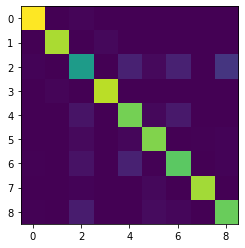

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       800
         1.0       0.98      0.97      0.98       700
         2.0       0.70      0.59      0.65       723
         3.0       0.97      0.98      0.98       714
         4.0       0.79      0.84      0.82       737
         5.0       0.89      0.92      0.90       685
         6.0       0.80      0.82      0.81       716
         7.0       0.99      0.96      0.98       701
         8.0       0.81      0.86      0.83       704

    accuracy                           0.88      6480
   macro avg       0.88      0.88      0.88      6480
weighted avg       0.88      0.88      0.88      6480



In [76]:
randomforest_model = RandomForestClassifier(oob_score=True, warm_start=True, n_jobs=-1)
randomforest_model.fit(xtrain2_preprocessed, ytrain2)
eval_ml_model(randomforest_model, xtest2_preprocessed, ytest2)

Using the preprocessed dataset gives us significantly better results than PCA. This is telling us that we need the full variance of the data.

### Grid Search

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done   6 out of  15 | elapsed:  3.4min remaining:  5.1min
[Parallel(n_jobs=6)]: Done   8 out of  15 | elapsed:  5.1min remaining:  4.4min
[Parallel(n_jobs=6)]: Done  10 out of  15 | elapsed:  5.1min remaining:  2.6min
[Parallel(n_jobs=6)]: Done  12 out of  15 | elapsed:  9.4min remaining:  2.3min
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:  9.7min finished


{'n_estimators': 1000}


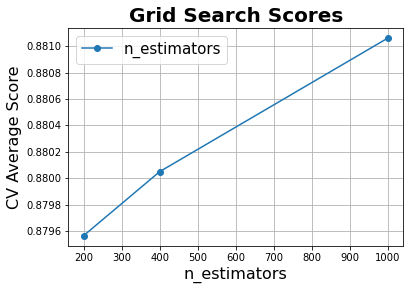

In [77]:
gridsearch_and_plot(randomforest_model, "n_estimators", [ 200, 400, 1000], xtrain2_preprocessed, ytrain2)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   28.8s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   43.7s
[Parallel(n_jobs=6)]: Done  12 out of  20 | elapsed:  1.4min remaining:   55.0s
[Parallel(n_jobs=6)]: Done  15 out of  20 | elapsed:  2.0min remaining:   39.2s
[Parallel(n_jobs=6)]: Done  18 out of  20 | elapsed:  2.0min remaining:   13.4s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  2.1min finished


{'max_depth': 75}


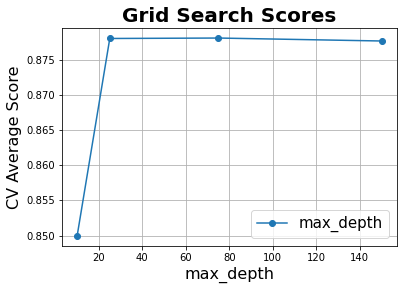

In [78]:
gridsearch_and_plot(randomforest_model, "max_depth", [10, 25, 75, 150], xtrain2_preprocessed, ytrain2)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   30.9s
[Parallel(n_jobs=6)]: Done   6 out of  15 | elapsed:   34.9s remaining:   52.5s
[Parallel(n_jobs=6)]: Done   8 out of  15 | elapsed:   55.7s remaining:   48.7s
[Parallel(n_jobs=6)]: Done  10 out of  15 | elapsed:   56.1s remaining:   28.0s
[Parallel(n_jobs=6)]: Done  12 out of  15 | elapsed:   58.6s remaining:   14.6s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:  1.1min finished


{'min_impurity_decrease': 0.0001}


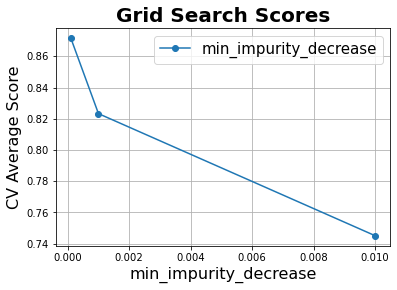

In [79]:
gridsearch_and_plot(randomforest_model, "min_impurity_decrease", [0.0001, 0.001, 0.01], xtrain2_preprocessed, ytrain2)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   13.1s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   32.0s
[Parallel(n_jobs=6)]: Done  17 out of  25 | elapsed:   37.9s remaining:   17.8s
[Parallel(n_jobs=6)]: Done  20 out of  25 | elapsed:   59.7s remaining:   14.9s
[Parallel(n_jobs=6)]: Done  23 out of  25 | elapsed:  1.0min remaining:    5.4s
[Parallel(n_jobs=6)]: Done  25 out of  25 | elapsed:  1.1min finished


{'max_leaf_nodes': 128}


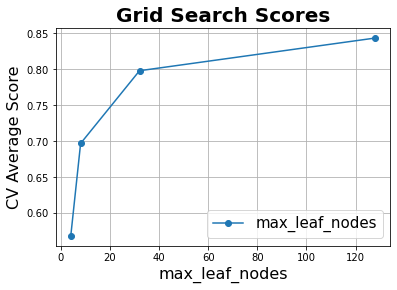

In [80]:
gridsearch_and_plot(randomforest_model, "max_leaf_nodes", [1,4,8,32,128], xtrain2_preprocessed, ytrain2)

### Putting it all together

Our grid search shows that the default values are quiet decent and unless we go to extremes they dont affect the outcome drastically. I will use the best values nevertheless.

In [81]:
randomforest_model = RandomForestClassifier(oob_score=True, warm_start=True, n_estimators=1000, max_depth=100, n_jobs=-1)

Now that we have our model, we should check if it is overfitting. I did a 10 fold cross validation and scores are consistent. 

In [82]:
scores = cross_val_score(randomforest_model, xtrain2_preprocessed, ytrain2, cv=10, n_jobs=-1)
print('Scores =', scores)

Scores = [0.89015152 0.88257576 0.88573232 0.875      0.88489057 0.89162458
 0.87752525 0.87984007 0.88678451 0.87920875]


Accuracy score:  0.879320987654321
Confusion matrix: 
 [[778   2  14   1   2   1   1   0   1]
 [  3 683   0  14   0   0   0   0   0]
 [  9   0 421   1  72  18  75   0 127]
 [  3  12   0 699   0   0   0   0   0]
 [  2   0  37   0 625  18  51   1   3]
 [  1   0  17   0  17 635   3   3   9]
 [  6   0  34   0  78   5 585   0   8]
 [  1   0   5   1   0  16   5 673   0]
 [  4   0  61   1   1  22  16   0 599]]
Plotting confusion matrix


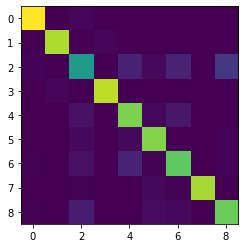

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97       800
         1.0       0.98      0.98      0.98       700
         2.0       0.71      0.58      0.64       723
         3.0       0.97      0.98      0.98       714
         4.0       0.79      0.85      0.82       737
         5.0       0.89      0.93      0.91       685
         6.0       0.79      0.82      0.81       716
         7.0       0.99      0.96      0.98       701
         8.0       0.80      0.85      0.83       704

    accuracy                           0.88      6480
   macro avg       0.88      0.88      0.88      6480
weighted avg       0.88      0.88      0.88      6480



In [83]:
randomforest_model.fit(xtrain2_preprocessed, ytrain2)
eval_ml_model(randomforest_model, xtest2_preprocessed, ytest2)

### Augmented inputs

In [84]:
def create_augmented_images(xtrain, ytrain, size):
    xtrain_extended = np.repeat(xtrain.reshape(xtrain2.shape[0], 28, 28, 1), size, axis=0)
    ytrain_extended = np.repeat(ytrain, size, axis=0)
    
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                                 horizontal_flip=True, zoom_range=0.1, fill_mode='nearest', shear_range=0.1,
                                 rotation_range=10)
    it_train = datagen.flow(xtrain_extended, ytrain_extended, batch_size=len(xtrain_extended), shuffle=True)
    
    result = it_train.next()
    return result[0].reshape(result[0].shape[0], 28*28), result[1]

In [85]:
xtrain2_augmented_2x, ytrain2_augmented_2x = create_augmented_images(xtrain2_preprocessed, ytrain2, 2)

Augmented shape: (95040, 784)


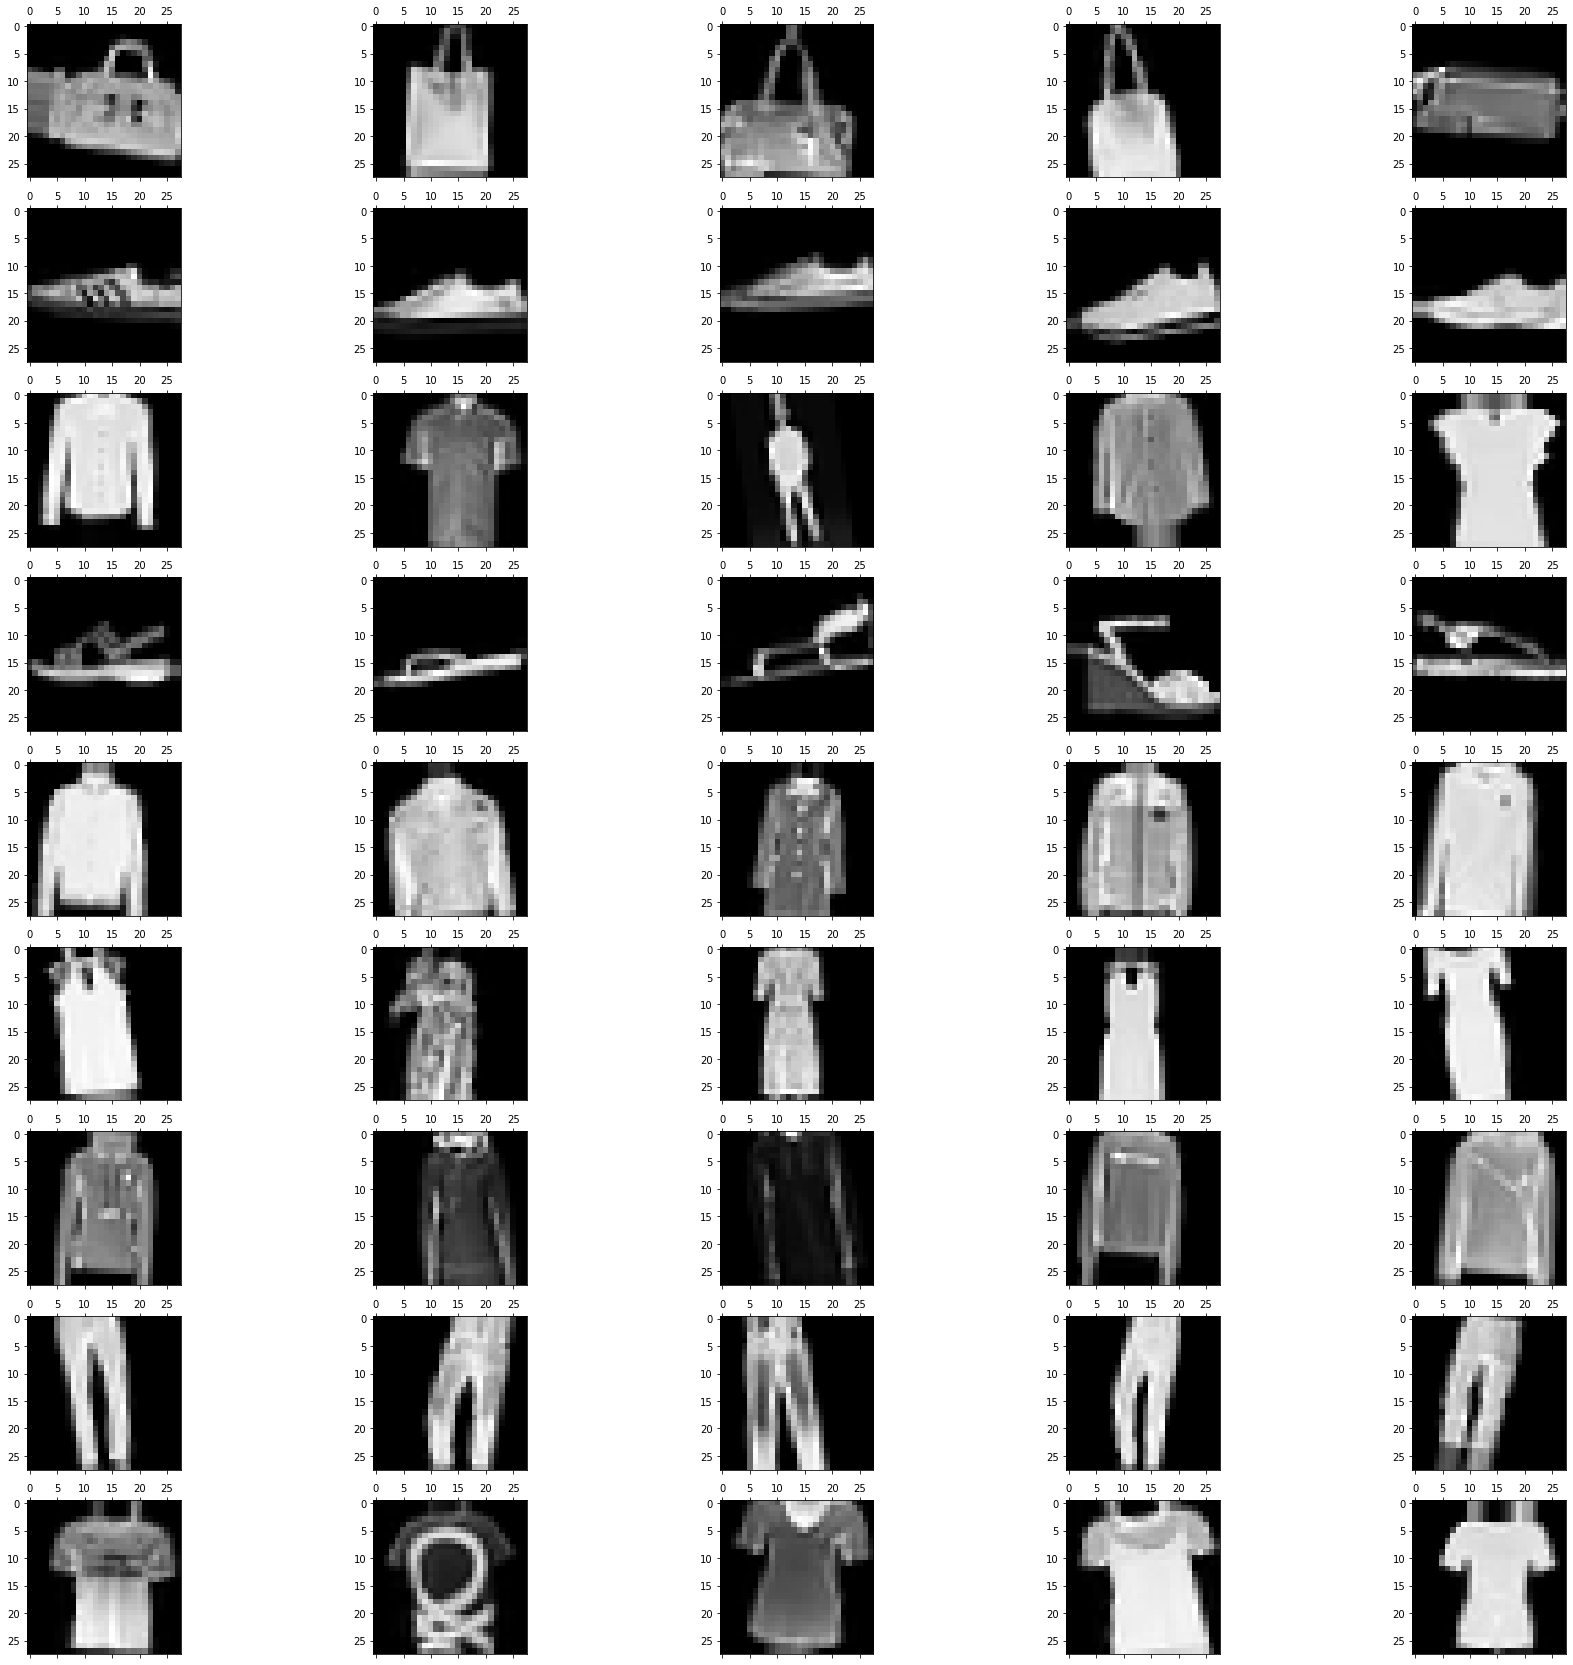

In [86]:
print("Augmented shape:", xtrain2_augmented_2x.shape)
fig, axes = plt.subplots(9, 5, figsize=(30, 30))

for i in range(0, num_classes):
    index = np.argwhere(ytrain2_augmented_2x == i)[0:5]
    for j in range(0, 5):
        axes[i , j].matshow(xtrain2_augmented_2x[index[j]].reshape(28,28), cmap=plt.get_cmap('gray'))

Accuracy score:  0.8200617283950618
Confusion matrix: 
 [[749   8   4  13   2   2  20   1   1]
 [  0 613   0  87   0   0   0   0   0]
 [  8   0 301   4  80  45 111   2 172]
 [  2  23   0 687   0   2   0   0   0]
 [  6   0  33   0 537  44 111   2   4]
 [  1   0  21   0  19 613   3  17  11]
 [  9   0  51   0  83   9 560   0   4]
 [  1   0   2   1   2   9   9 677   0]
 [  8   0  42   0   2  59  14   2 577]]
Plotting confusion matrix


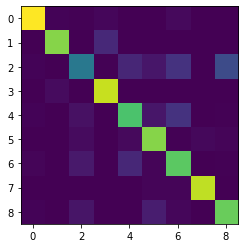

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       800
         1.0       0.95      0.88      0.91       700
         2.0       0.66      0.42      0.51       723
         3.0       0.87      0.96      0.91       714
         4.0       0.74      0.73      0.73       737
         5.0       0.78      0.89      0.84       685
         6.0       0.68      0.78      0.73       716
         7.0       0.97      0.97      0.97       701
         8.0       0.75      0.82      0.78       704

    accuracy                           0.82      6480
   macro avg       0.82      0.82      0.81      6480
weighted avg       0.82      0.82      0.81      6480



In [87]:
randomforest_2x_model = RandomForestClassifier(oob_score=True, warm_start=True, n_estimators=1000, max_depth=100, n_jobs=-1)
randomforest_2x_model.fit(xtrain2_augmented_2x, ytrain2_augmented_2x)
eval_ml_model(randomforest_2x_model, xtest2_preprocessed, ytest2)

### Discussion

Decision Trees have low bias because they inherently overfit to the training data. Each prediction is practically looking up old events, and finding one that gives the minimum error. This means significant variance. However when we use many many different trees in parallel and chose the dominant decision, we average out the variance. That is why increasing the number of estimators helps with accuracy in our grid search, but not much. RandomForest has a drawback, if we have a dominant label in our set, more trees would vote for that and that would create a bias. However our training set seems to have a uniform distribution of classes. 

We have quite a bit number of features, therefore our trees need to be look at many of the features and be sophisticated enough to make complex decisions. Therefore maximum_depth is important. As we can see in the grid plot, our accuracy increases with increasing depth and saturates after 50. Meaning that 50 splits are sufficient to capture all the variance. If we decrease the splits, we will force the tree to a higher bias at the loss of variance; and we will lose accuracy.

Impurity is the measure of the homogeneity in a leaf. A tree with higher degree of impurity would have higher bias and lower variance. However as can be seen with our pca experiment, our forest requires all the details(variance) it can get. So if we allow more impurity our performance suffers. This can be seen in the grid search plot.

A tree will be able to make more sophisticated decisions with more leafs. In other words it's variance will increase with increase with each additional node. However it's bias will probably take a hit too. So if we limit the number of leafs, we limit the variance and force the tree to a lower variance state. Unfortunately for such a non-linear dataset this means lower accuracy. As we can see in the plot, our performance increase with max_leaf_nodes.

After setting all the optimal hyper parameters we got an accuracy of 88%, which is quite decent. However our tree cannot compete with a neural network (~%94 accuracy) as it is trying to find similarities between the test data and training data.  On the other hand neural network uses digital image processing filters to find edges and  constructs higher level features, which then it interprets. It is inherently the more powerful tool for this particular problem.   

This becomes even more evident when we try to use augmented data. Since neural networks find patterns their performance does not drop, and sometimes even increase. On the other hand as we can see from the confusion matrix above, decision tree finds it even more difficult to classify hard cases. Therefore it loses significant accuracy (88%-> 82%).

----------------------------------------------------------------------------------------------------------------------

# 2nd Method: KNN

#### With PCA

Accuracy score:  0.8608024691358025
Confusion matrix: 
 [[779   5   3   0   2   3   8   0   0]
 [  1 694   0   5   0   0   0   0   0]
 [  5   1 458   0  54  13  81   1 110]
 [  5  66   3 639   0   0   1   0   0]
 [  1   0  81   0 576  17  58   1   3]
 [  2   0  25   0  25 608   4   3  18]
 [  1   0  70   0  72   7 555   0  11]
 [  1   0   4   0   0  14   6 673   3]
 [  6   0  67   0   2  20  13   0 596]]
Plotting confusion matrix


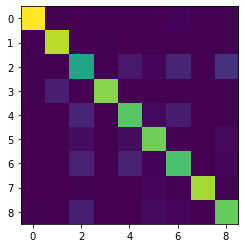

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       800
         1.0       0.91      0.99      0.95       700
         2.0       0.64      0.63      0.64       723
         3.0       0.99      0.89      0.94       714
         4.0       0.79      0.78      0.78       737
         5.0       0.89      0.89      0.89       685
         6.0       0.76      0.78      0.77       716
         7.0       0.99      0.96      0.98       701
         8.0       0.80      0.85      0.82       704

    accuracy                           0.86      6480
   macro avg       0.86      0.86      0.86      6480
weighted avg       0.86      0.86      0.86      6480



In [88]:
knn_pca_model = KNeighborsClassifier(n_jobs=-1)
knn_pca_model.fit(xtrain_pca, ytrain2)
eval_ml_model(knn_pca_model, xtest_pca, ytest2)

#### Without PCA

Accuracy score:  0.8581790123456791
Confusion matrix: 
 [[773   5   5   0   4   2  11   0   0]
 [  1 695   0   4   0   0   0   0   0]
 [  4   1 449   0  57  11  82   1 118]
 [  5  74   3 631   0   0   1   0   0]
 [  1   0  78   0 578  17  59   1   3]
 [  2   0  26   0  27 606   4   3  17]
 [  1   0  73   0  65   5 561   0  11]
 [  1   0   4   0   0  13   6 674   3]
 [  6   0  71   0   0  19  14   0 594]]
Plotting confusion matrix


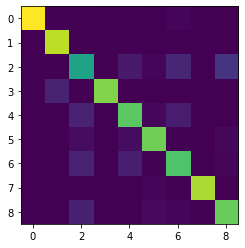

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       800
         1.0       0.90      0.99      0.94       700
         2.0       0.63      0.62      0.63       723
         3.0       0.99      0.88      0.94       714
         4.0       0.79      0.78      0.79       737
         5.0       0.90      0.88      0.89       685
         6.0       0.76      0.78      0.77       716
         7.0       0.99      0.96      0.98       701
         8.0       0.80      0.84      0.82       704

    accuracy                           0.86      6480
   macro avg       0.86      0.86      0.86      6480
weighted avg       0.86      0.86      0.86      6480



In [89]:
knn_model = KNeighborsClassifier(n_jobs=-1)
knn_model.fit(xtrain2_preprocessed, ytrain2)
eval_ml_model(knn_model, xtest2_preprocessed, ytest2)

KNN performs better with a lower number of features. If we have too many dimensions it may overfit (due too much variance). This is known as the Curse of Dimensionality (as discussed in hw 7). To deal with this problem we need to perform PCA. 

### Grid Search

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed: 23.6min
[Parallel(n_jobs=6)]: Done  17 out of  25 | elapsed: 24.0min remaining: 11.3min
[Parallel(n_jobs=6)]: Done  20 out of  25 | elapsed: 32.0min remaining:  8.0min
[Parallel(n_jobs=6)]: Done  23 out of  25 | elapsed: 32.1min remaining:  2.8min
[Parallel(n_jobs=6)]: Done  25 out of  25 | elapsed: 33.5min finished


{'n_neighbors': 9}


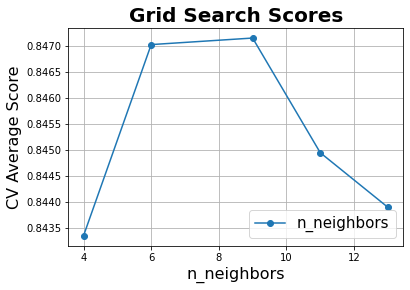

In [90]:
gridsearch_and_plot(knn_pca_model, "n_neighbors", [4, 6, 9, 11, 13], xtrain2_preprocessed, ytrain2)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of  10 | elapsed:  8.0min remaining: 18.6min
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:  8.0min remaining:  8.0min
[Parallel(n_jobs=6)]: Done   7 out of  10 | elapsed: 13.4min remaining:  5.7min
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed: 13.4min finished


{'weights': 'distance'}


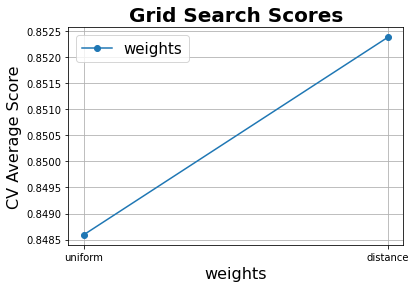

In [91]:
gridsearch_and_plot(knn_pca_model, "weights", ['uniform', 'distance'], xtrain2_preprocessed, ytrain2)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of  10 | elapsed:  8.3min remaining: 19.4min
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:  8.3min remaining:  8.3min
[Parallel(n_jobs=6)]: Done   7 out of  10 | elapsed: 13.6min remaining:  5.8min
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed: 13.6min finished


{'p': 1}


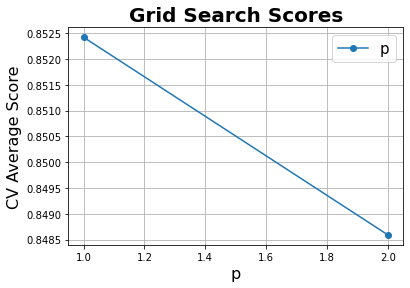

In [92]:
gridsearch_and_plot(knn_pca_model, "p", [1,2], xtrain2_preprocessed, ytrain2)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done  12 out of  20 | elapsed: 12.4min remaining:  8.2min
[Parallel(n_jobs=6)]: Done  15 out of  20 | elapsed: 14.1min remaining:  4.7min
[Parallel(n_jobs=6)]: Done  18 out of  20 | elapsed: 19.1min remaining:  2.1min
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed: 19.9min finished


{'metric': 'correlation'}


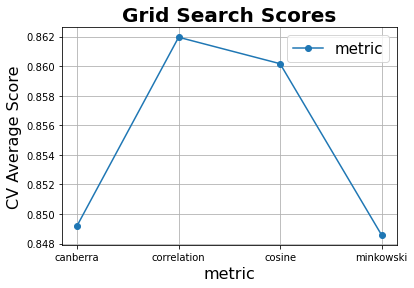

In [93]:
gridsearch_and_plot(knn_pca_model, "metric", ['canberra','correlation', 'cosine', 'minkowski'], xtrain2_preprocessed, ytrain2)

### Putting it all together

Grid search showed us that our initial parameters were very close to optimal. We use the optimized one nevertheless and do a cross_validation to verify.

In [94]:
knn_pca_model = KNeighborsClassifier(metric='correlation', weights='distance', n_neighbors=9, p=1, n_jobs=-1)
scores = cross_val_score(knn_pca_model, xtrain_pca, ytrain2, cv=10, n_jobs=-1)
print('Scores =', scores)

Scores = [0.86279461 0.86153199 0.8655303  0.86237374 0.86973906 0.86700337
 0.85690236 0.86447811 0.8655303  0.86595118]


Accuracy score:  0.8652777777777778
Confusion matrix: 
 [[775   8   4   1   2   0   7   1   2]
 [  1 694   0   5   0   0   0   0   0]
 [  7   0 431   1  60  13  75   1 135]
 [  3  61   2 647   0   1   0   0   0]
 [  3   0  57   0 594  18  62   1   2]
 [  3   0  17   1  24 607   2   4  27]
 [  3   0  53   1  70   5 569   0  15]
 [  1   0   5   0   0  13   5 676   1]
 [  5   1  51   3   1  17  12   0 614]]
Plotting confusion matrix


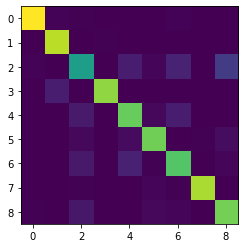

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       800
         1.0       0.91      0.99      0.95       700
         2.0       0.70      0.60      0.64       723
         3.0       0.98      0.91      0.94       714
         4.0       0.79      0.81      0.80       737
         5.0       0.90      0.89      0.89       685
         6.0       0.78      0.79      0.79       716
         7.0       0.99      0.96      0.98       701
         8.0       0.77      0.87      0.82       704

    accuracy                           0.87      6480
   macro avg       0.86      0.87      0.86      6480
weighted avg       0.87      0.87      0.86      6480



In [95]:
knn_pca_model.fit(xtrain_pca, ytrain2)
eval_ml_model(knn_pca_model, xtest_pca, ytest2)

In [96]:
knn_model = KNeighborsClassifier(metric='correlation', weights='distance', n_neighbors=9, p=1, n_jobs=-1)
scores = cross_val_score(knn_model, xtrain2_preprocessed, ytrain2, cv=10, n_jobs=-1)
print('Scores =', scores)

Scores = [0.86595118 0.86111111 0.86805556 0.8587963  0.87289562 0.871633
 0.86174242 0.8638468  0.8655303  0.86637205]


Accuracy score:  0.8685185185185185
Confusion matrix: 
 [[778   4   3   0   7   2   4   0   2]
 [  1 696   0   3   0   0   0   0   0]
 [  5   0 412   1  78  10  72   2 143]
 [  4  92   0 616   0   1   0   0   1]
 [  1   0  38   0 635  12  49   1   1]
 [  2   0  16   0  26 611   2   6  22]
 [  1   0  39   0  82   5 575   1  13]
 [  1   0   2   0   0  10   3 682   3]
 [  4   0  46   0   3  13  13   2 623]]
Plotting confusion matrix


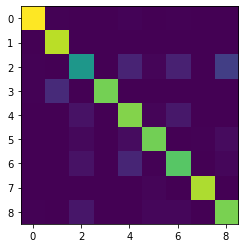

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       800
         1.0       0.88      0.99      0.93       700
         2.0       0.74      0.57      0.64       723
         3.0       0.99      0.86      0.92       714
         4.0       0.76      0.86      0.81       737
         5.0       0.92      0.89      0.91       685
         6.0       0.80      0.80      0.80       716
         7.0       0.98      0.97      0.98       701
         8.0       0.77      0.88      0.82       704

    accuracy                           0.87      6480
   macro avg       0.87      0.87      0.87      6480
weighted avg       0.87      0.87      0.87      6480



In [97]:
knn_model.fit(xtrain2_preprocessed, ytrain2)
eval_ml_model(knn_model, xtest2_preprocessed, ytest2)

### Augmented inputs

Accuracy score:  0.8001543209876543
Confusion matrix: 
 [[765   3   5   0   4   2  21   0   0]
 [  0 698   0   2   0   0   0   0   0]
 [ 10   0 332   1 102  13  88   4 173]
 [  3 190   0 514   1   6   0   0   0]
 [  2   0  63   0 567  22  80   1   2]
 [  2   0  15   0  53 575   3  13  24]
 [  4   0  60   0 174   4 460   1  13]
 [  1   0   3   0   3  14   3 676   1]
 [  6   1  48   0   7  28  11   5 598]]
Plotting confusion matrix


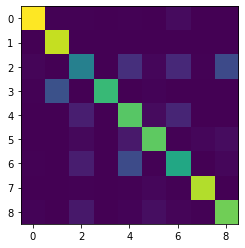

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       800
         1.0       0.78      1.00      0.88       700
         2.0       0.63      0.46      0.53       723
         3.0       0.99      0.72      0.84       714
         4.0       0.62      0.77      0.69       737
         5.0       0.87      0.84      0.85       685
         6.0       0.69      0.64      0.67       716
         7.0       0.97      0.96      0.97       701
         8.0       0.74      0.85      0.79       704

    accuracy                           0.80      6480
   macro avg       0.81      0.80      0.80      6480
weighted avg       0.81      0.80      0.80      6480



In [98]:
knn_2x_model = KNeighborsClassifier(metric='correlation', weights='distance', n_neighbors=9, p=1, n_jobs=-1)
knn_2x_model.fit(xtrain2_augmented_2x, ytrain2_augmented_2x)
eval_ml_model(knn_2x_model, xtest2_preprocessed, ytest2)

### Discussion

KNN alogirthm works on the similarity concept. For each data sample, it finds the closest anecdotes and assumes that the new sample belongs to the common group. Therefore two factors play an important role: Distance and number of neighbors.

As the number of neighbors changes our accuracy will change a lot. If we look at a very high number of neighbors, our model will have a high bias and it will no longer be able to make high precision decisions. On the other hand if it looks at too few neighbors then it will overfit to the data and will have too much variance. This behaviour can be seen in the grid search. Our accuracy increases as the number of neighbors increase to 9 and starts to decrease after we exceed 9. So 9 is the optimal spot for variance-bias relationship.

The second important thing is how we measure the distance between neighbors. When we have this many features, regular distance methods like euclidian is no longer meaningful. Therefore using metrics that would measure similarity would work better. This is why correlation and cosine metrics perform bettern than the others. cosine looks at where the data points are in the space and calculates the angle between them. On the other hand correlation looks for how similar the pixel values are. 

Since our dataset is quite large, and dimensions are quite high, it might make sense to pay more attention to very close neighbors than the far away ones. This way we can create better seperated groups in the space, and decrease the variance. Grid search shows a similar result. However performance difference is minimal.

Our results for KNN are very similar to RandomForest, we get 87% accuracy. This is expected. Both methhods are grouping the data into subsets and looking up old decisions. Since knn is actually comparing the test data against more number of previous cases, KNN would probably do a bit better against never seen data. However it will probably fall short when the decision is not clear and voting is favorable. It will perform quite poorly compared to a neural network though. Whatever we said for the RandomForest applies to KNN as well. Neural network learns high level features, while KNN will try to match the data to a similar case. Therefore just like RandomForest, KNN performed worse on augmented images, which varied quite a bit and were difficult to match against (%87 -> %81). 

----------------------------------------------------------------------------------------------------------------------

(4 points) Q3. So far, we gave you both the training set and the test set for your models. But that is not what happens in real life. In real life, you prepare your model based on the training set to evaluate it on a test set to which you will have access only at some point in the future. To simulate that situation better, we are adding this question, which is related to evaluating your algorithms in Q1 and Q2 for predicting previously unseen data. On Friday, 5/22 at 12:01am, we will send you a collection of new samples without their associated labels. Your job is to run the algorithms you created for Q1 and Q2 on this new dataset and create a CSV file with 3 columns, which includes the labels that you predicted with your 3 proposed algorithms in the following order: first column is the NN from Q1, second column is the first model from Q2, and third column is the second model from Q2.

In [99]:
xnew = np.loadtxt('xnew.csv')

In [100]:
xnew_norm = ((255.0 - xnew).astype("float32")) / 255.0

In [101]:
xnew_preprocessed_nn = xnew_norm.reshape(xnew_norm.shape[0], 28, 28, 1)
xnew_preprocessed_ml = xnew_norm.reshape(xnew_norm.shape[0], 28*28)
print(xnew_preprocessed_nn.shape)
print(xnew_preprocessed_ml.shape)

(1080, 28, 28, 1)
(1080, 784)


In [102]:
xnew_predictions_nn = np.argmax(nn_final_model_trained.predict(xnew_preprocessed_nn), axis=1) + class_name_bias

In [103]:
xnew_predictions_knn = knn_pca_model.predict(pca.transform(xnew_norm)) + class_name_bias
xnew_predictions_rfst = randomforest_model.predict(xnew_preprocessed_ml) + class_name_bias

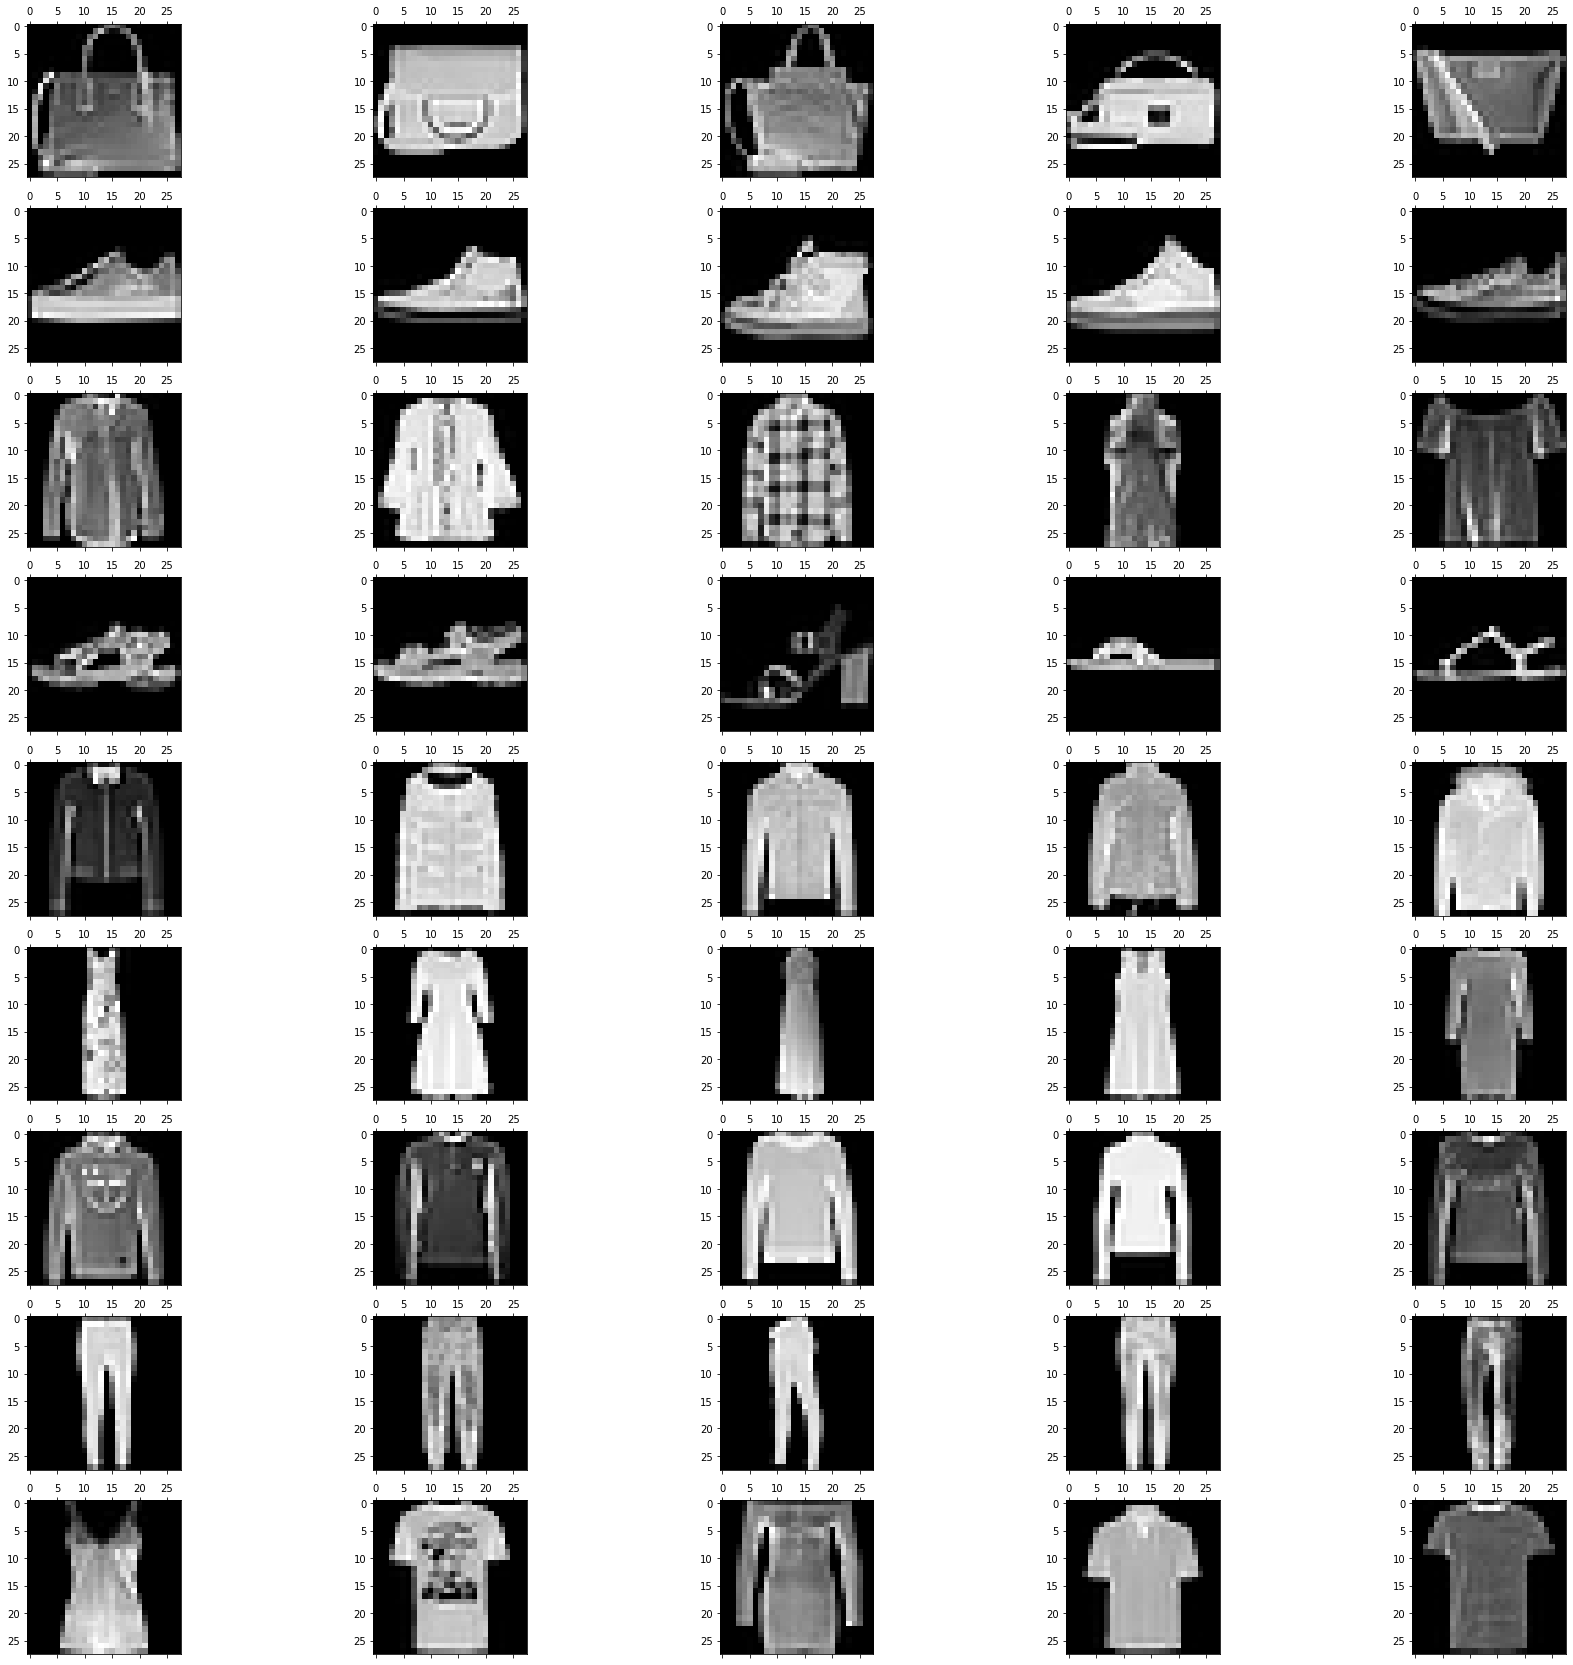

In [104]:
fig, axes = plt.subplots(9, 5, figsize=(30, 30))

for i in range(0, num_classes):
    index = np.argwhere(xnew_predictions_nn == i + class_name_bias)[0:5]
    for j in range(0, 5):
        axes[i, j].matshow(xnew_norm[index[j]].reshape(28,28), cmap=plt.get_cmap('gray'))

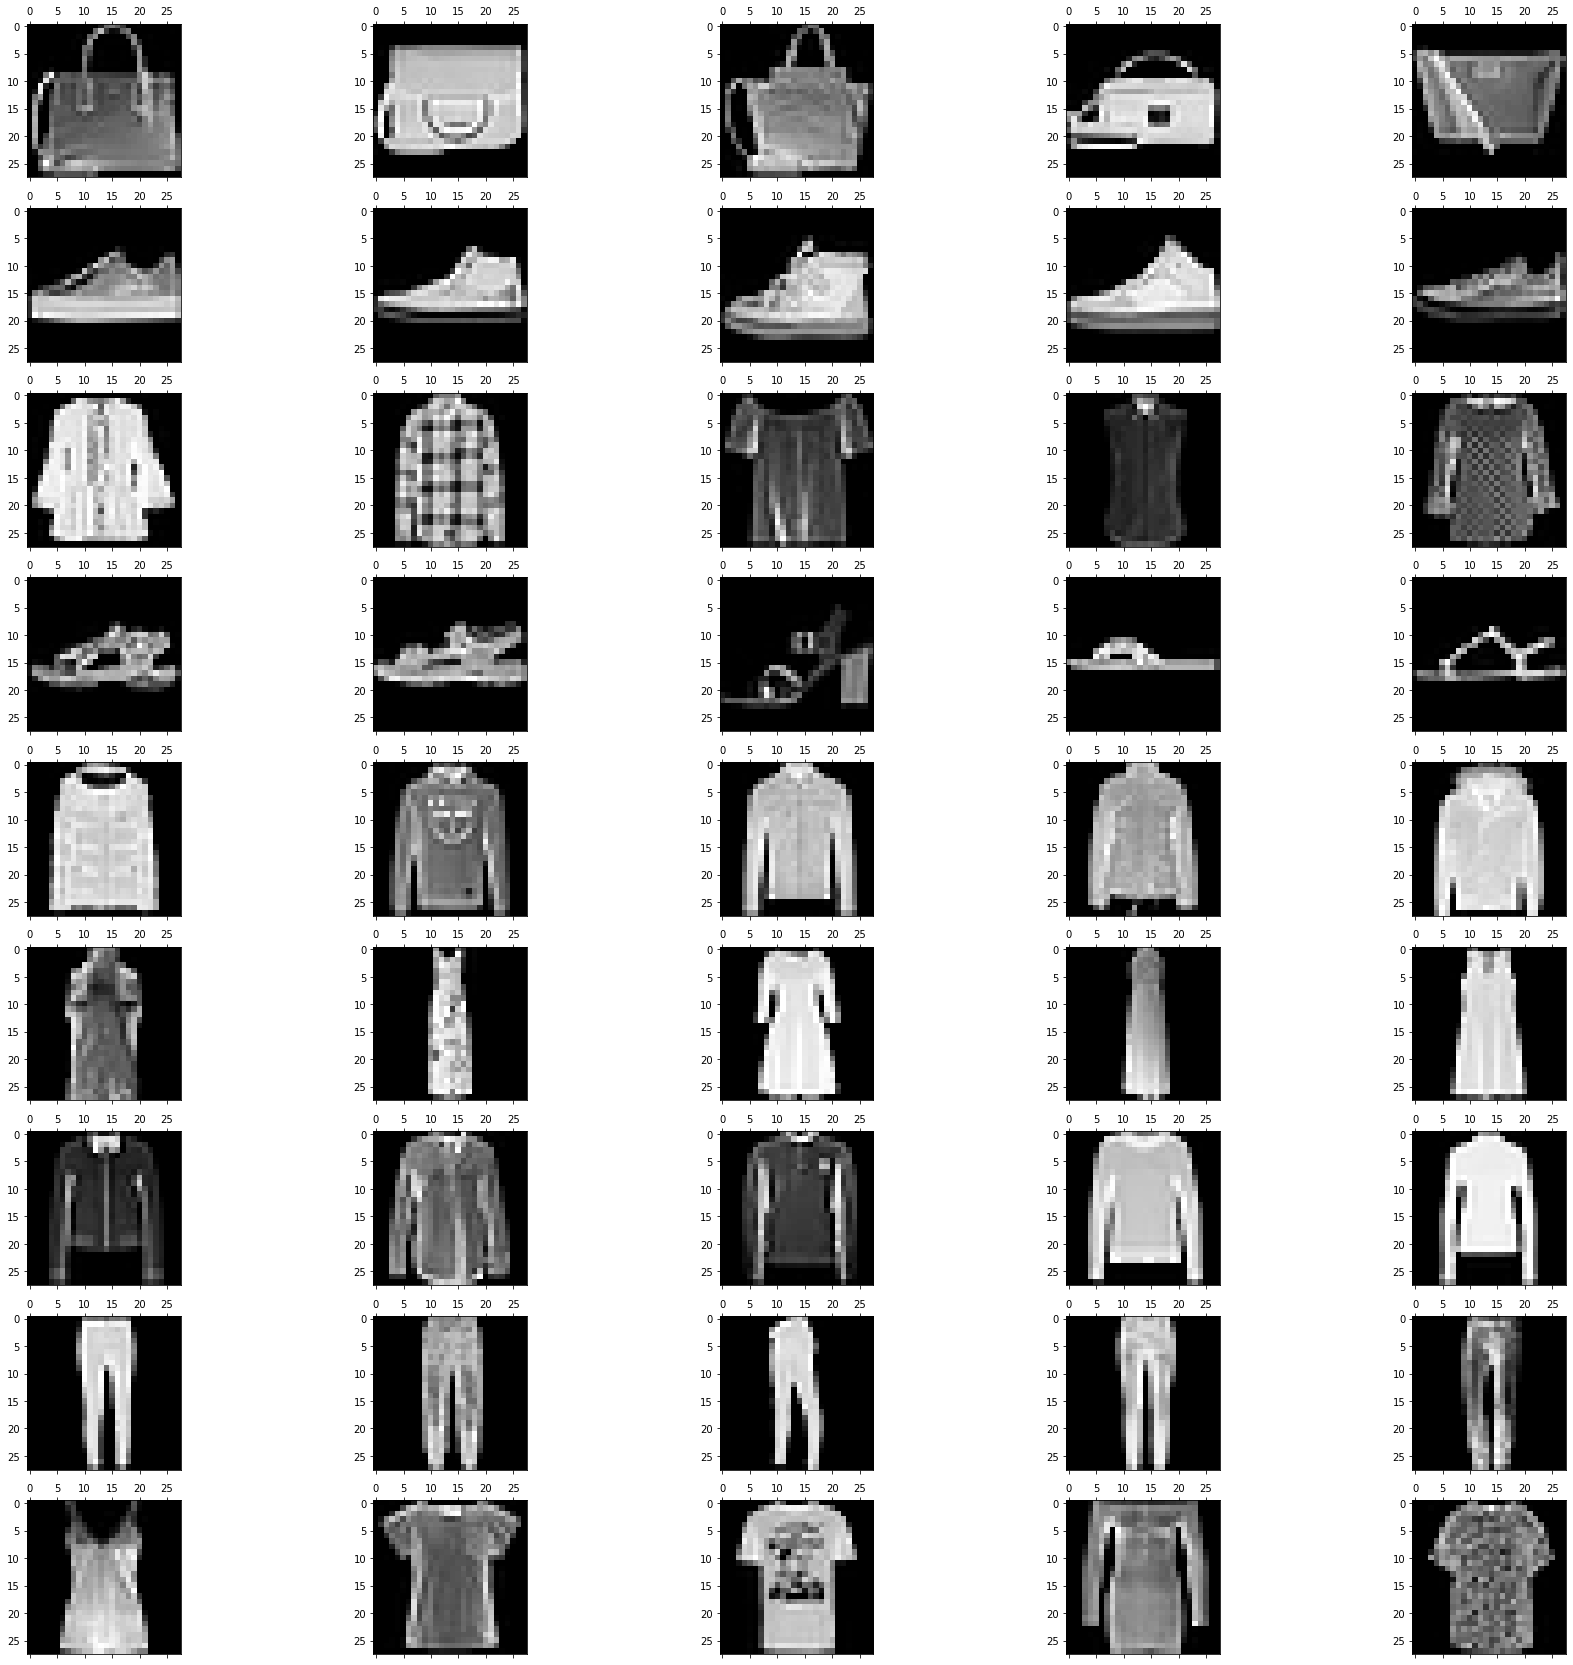

In [105]:
fig, axes = plt.subplots(9, 5, figsize=(30, 30))

for i in range(0, num_classes):
    index = np.argwhere(xnew_predictions_rfst == i + class_name_bias)[0:5]
    for j in range(0, 5):
        axes[i, j].matshow(xnew_norm[index[j]].reshape(28,28), cmap=plt.get_cmap('gray'))

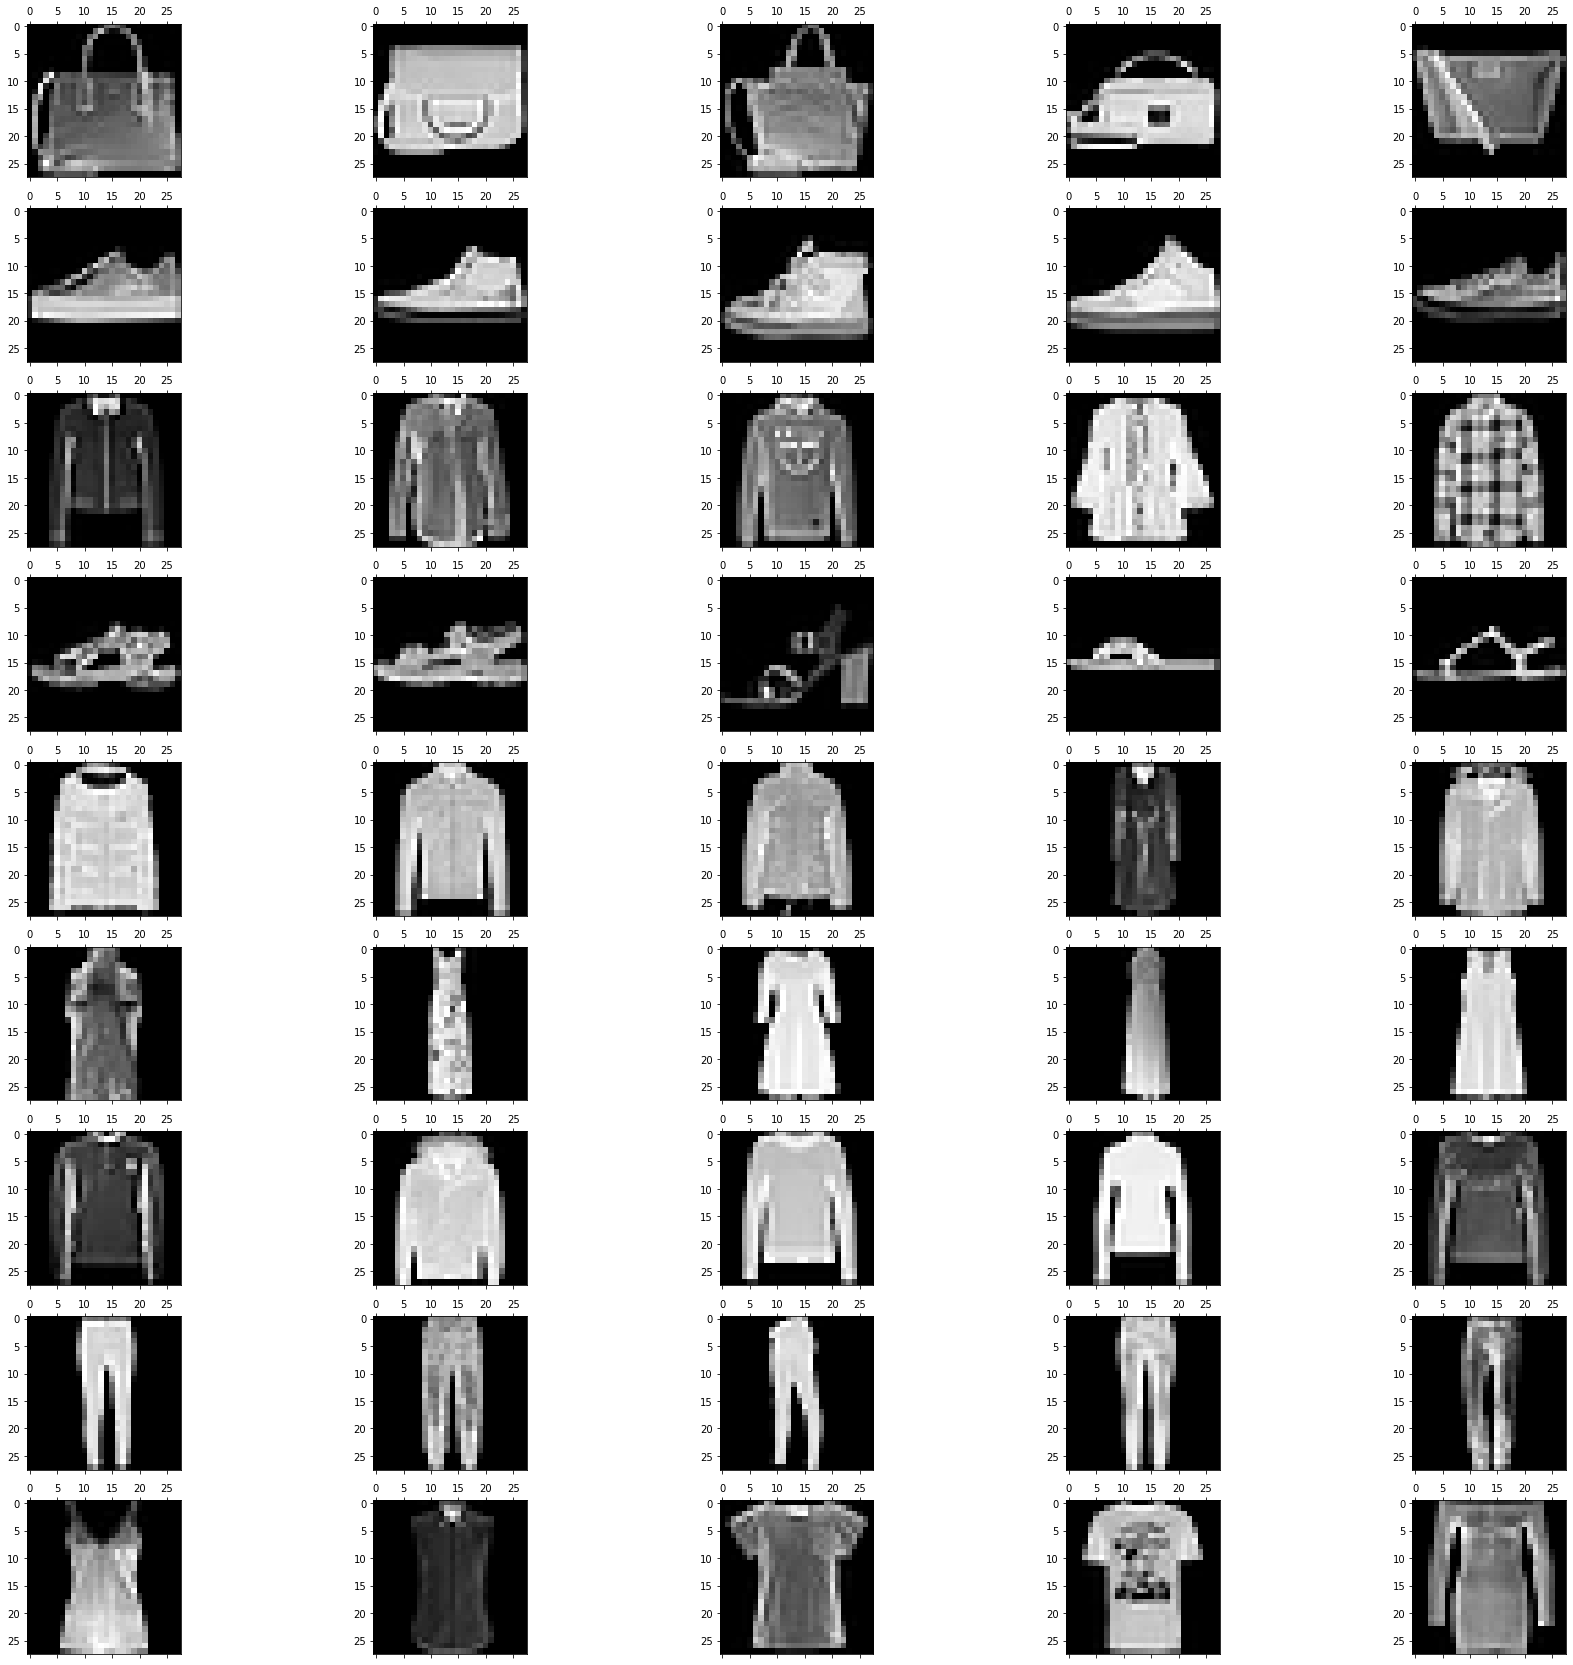

In [106]:
fig, axes = plt.subplots(9, 5, figsize=(30, 30))

for i in range(0, num_classes):
    index = np.argwhere(xnew_predictions_knn == i + class_name_bias)[0:5]
    for j in range(0, 5):
        axes[i, j].matshow(xnew_norm[index[j]].reshape(28,28), cmap=plt.get_cmap('gray'))

In [107]:
print(xnew_predictions_nn.shape)
print(xnew_predictions_rfst.shape)
print(xnew_predictions_knn.shape)

(1080,)
(1080,)
(1080,)


In [108]:
final_predictions = np.transpose(np.array([xnew_predictions_nn, xnew_predictions_rfst, xnew_predictions_knn]))

In [109]:
final_predictions.shape

(1080, 3)

In [110]:
unique_elements_final, counts_elements_final = np.unique(final_predictions, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements_final, counts_elements_final)))

Frequency of unique values of the said array:
[[247. 248. 249. 250. 251. 252. 253. 254. 255.]
 [365. 399. 344. 353. 343. 360. 379. 360. 337.]]


In [111]:
unique_elements_final, counts_elements_final = np.unique(ytrain, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements_final, counts_elements_final)))

Frequency of unique values of the said array:
[[ 247.  248.  249.  250.  251.  252.  253.  254.  255.]
 [5200. 5300. 5277. 5286. 5263. 5315. 5284. 5299. 5296.]]


In [112]:
np.savetxt("final_predictions.csv", final_predictions, delimiter=",")